In [1]:
#Mount and import packages, read dataset to csv
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/My Drive/DAT490 Working Folder/Main model working folder/GSPCIndicators2.csv"
path2 = "/content/drive/My Drive/Colab Notebooks/TSPFundHist.csv"
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
gspc = pd.read_csv(path)
cfund = pd.read_csv(path2)

Mounted at /content/drive


In [2]:
gspc = gspc.dropna()
gspc.columns

Index(['Date', 'GSPC.Open', 'GSPC.High', 'GSPC.Low', 'GSPC.Close',
       'GSPC.Volume', 'GSPC.Adjusted', 'EMA', 'SMA', 'bb_dn', 'bb_mavg',
       'bb_up', 'bb_pctB', '2dayMomentum', '2dayROC', 'macd', 'macd_signal',
       'rsi', '3DaysOutcome', '3DaysPercent', '10DaysOutcome', '10DaysPercent',
       '20DaysOutcome', '20DaysPercent', '30DaysOutcome', '30DaysPercent',
       '45DaysOutcome', '45DaysPercent', '60DaysOutcome', '60DaysPercent'],
      dtype='object')

In [3]:
gspc['Date'] = pd.to_datetime(gspc['Date'])

In [4]:
gspc.head()

,Date,GSPC.Open,GSPC.High,GSPC.Low,GSPC.Close,GSPC.Volume,GSPC.Adjusted,EMA,SMA,bb_dn,...,10DaysOutcome,10DaysPercent,20DaysOutcome,20DaysPercent,30DaysOutcome,30DaysPercent,45DaysOutcome,45DaysPercent,60DaysOutcome,60DaysPercent
0,1928-02-17,17.040001,17.040001,17.040001,17.040001,0.0,17.040001,17.440963,17.4995,17.213740,...,17.570000,0.031103,18.360001,0.077465,18.91,0.109742,19.250000,0.129695,20.389999,0.196596
1,1928-02-20,16.950001,16.950001,16.950001,16.950001,0.0,16.950001,17.394205,17.4730,17.099954,...,17.670000,0.042478,18.459999,0.089085,19.02,0.122124,19.330000,0.140413,20.049999,0.182891
2,1928-02-21,17.110001,17.110001,17.110001,17.110001,0.0,17.110001,17.367138,17.4465,17.050103,...,17.580000,0.027469,18.650000,0.090006,18.99,0.109877,19.469999,0.137931,20.120001,0.175921
3,1928-02-23,17.129999,17.129999,17.129999,17.129999,0.0,17.129999,17.344553,17.4175,17.017607,...,17.639999,0.029772,18.600000,0.085814,19.23,0.122592,19.680000,0.148862,19.920000,0.162872
4,1928-02-24,17.180000,17.180000,17.180000,17.180000,0.0,17.180000,17.328881,17.4005,16.990697,...,17.930000,0.043655,18.780001,0.093132,19.27,0.121653,19.750000,0.149593,19.629999,0.142608


We want to engineer a target variable with enough instances to be exploitable, but enough separation from the mean which has shown very little predictability. To find a threshold, let's look at the distribution.

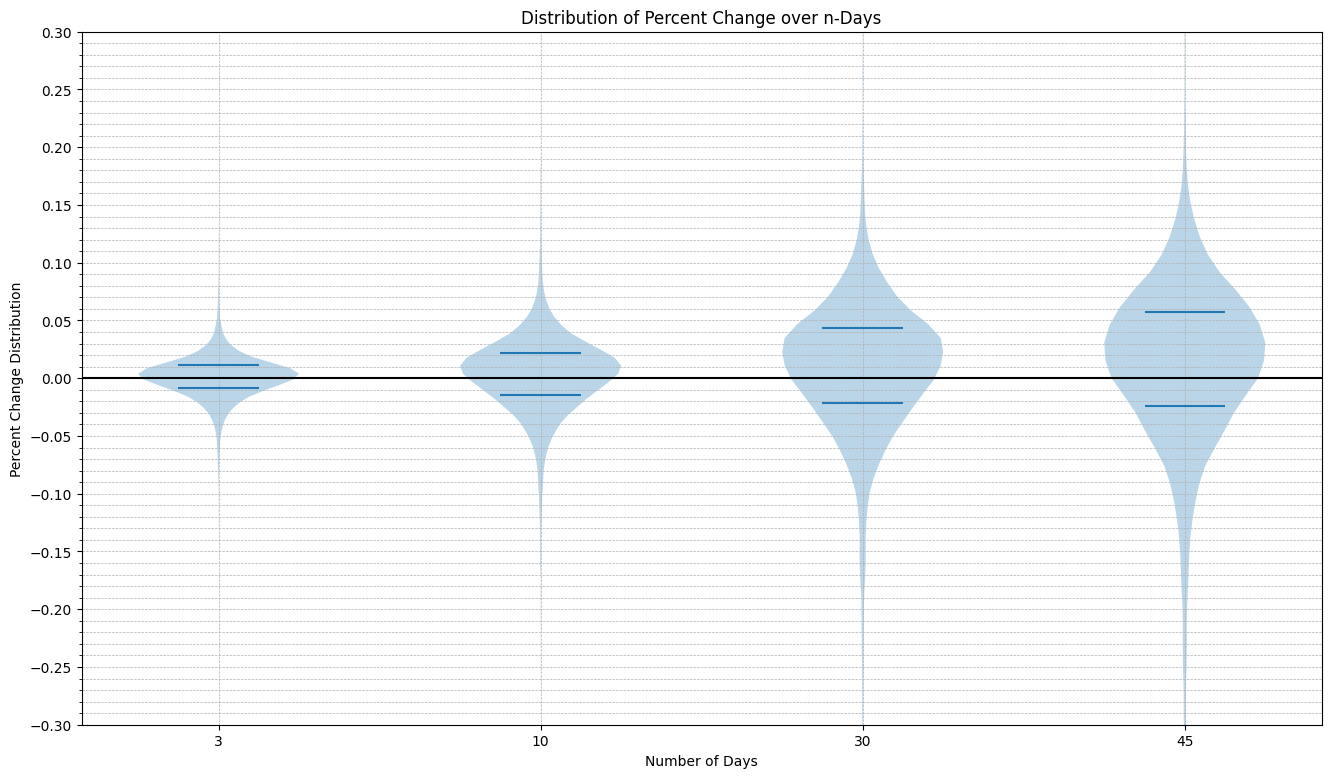

In [5]:
percents = pd.DataFrame(gspc[['3DaysPercent','10DaysPercent','30DaysPercent','45DaysPercent']].astype(float))
fig, ax = plt.subplots(figsize=(16,9))
ax.violinplot(percents,showextrema=False,quantiles=[[0.75,0.25],[0.75,0.25],[0.75,0.25],[0.75,0.25]])
ax.set_title('Distribution of Percent Change over n-Days')
ax.set_xlabel('Number of Days')
ax.set_ylabel('Percent Change Distribution')
ax.set_xticks([1,2,3,4])
ax.set_xticklabels(['3','10','30','45'])
ax.set_ylim(bottom=-0.3,top=0.3)
ax.set_yticks(np.arange(-0.3,0.31,0.05),minor=False)
ax.set_yticks(np.arange(-0.3,0.31,0.01),minor=True)
ax.grid(which='both', linestyle='--', linewidth=0.5)
plt.axhline(y=0,color='k',linestyle='-')
plt.show()

Considering that n=3 & n=10 did not have much separation off of the mean which has shown to be unreliable in predictive modeling, we expect the n=30 time frame to be the most beneficial. +/- 5% seems to be the bounds of the first and third quartiles, so we will utilize this threshold to test.

In [6]:
gspc['GSPC.Volume'] = gspc['GSPC.Volume'].shift(1)

In [7]:
gspc.head()

,Date,GSPC.Open,GSPC.High,GSPC.Low,GSPC.Close,GSPC.Volume,GSPC.Adjusted,EMA,SMA,bb_dn,...,10DaysOutcome,10DaysPercent,20DaysOutcome,20DaysPercent,30DaysOutcome,30DaysPercent,45DaysOutcome,45DaysPercent,60DaysOutcome,60DaysPercent
0,1928-02-17,17.040001,17.040001,17.040001,17.040001,NaN,17.040001,17.440963,17.4995,17.213740,...,17.570000,0.031103,18.360001,0.077465,18.91,0.109742,19.250000,0.129695,20.389999,0.196596
1,1928-02-20,16.950001,16.950001,16.950001,16.950001,0.0,16.950001,17.394205,17.4730,17.099954,...,17.670000,0.042478,18.459999,0.089085,19.02,0.122124,19.330000,0.140413,20.049999,0.182891
2,1928-02-21,17.110001,17.110001,17.110001,17.110001,0.0,17.110001,17.367138,17.4465,17.050103,...,17.580000,0.027469,18.650000,0.090006,18.99,0.109877,19.469999,0.137931,20.120001,0.175921
3,1928-02-23,17.129999,17.129999,17.129999,17.129999,0.0,17.129999,17.344553,17.4175,17.017607,...,17.639999,0.029772,18.600000,0.085814,19.23,0.122592,19.680000,0.148862,19.920000,0.162872
4,1928-02-24,17.180000,17.180000,17.180000,17.180000,0.0,17.180000,17.328881,17.4005,16.990697,...,17.930000,0.043655,18.780001,0.093132,19.27,0.121653,19.750000,0.149593,19.629999,0.142608


In [9]:
gspc = gspc.dropna()

In [10]:
gspc.head()

,Date,GSPC.Open,GSPC.High,GSPC.Low,GSPC.Close,GSPC.Volume,GSPC.Adjusted,EMA,SMA,bb_dn,...,10DaysOutcome,10DaysPercent,20DaysOutcome,20DaysPercent,30DaysOutcome,30DaysPercent,45DaysOutcome,45DaysPercent,60DaysOutcome,60DaysPercent
1,1928-02-20,16.950001,16.950001,16.950001,16.950001,0.0,16.950001,17.394205,17.4730,17.099954,...,17.670000,0.042478,18.459999,0.089085,19.02,0.122124,19.330000,0.140413,20.049999,0.182891
2,1928-02-21,17.110001,17.110001,17.110001,17.110001,0.0,17.110001,17.367138,17.4465,17.050103,...,17.580000,0.027469,18.650000,0.090006,18.99,0.109877,19.469999,0.137931,20.120001,0.175921
3,1928-02-23,17.129999,17.129999,17.129999,17.129999,0.0,17.129999,17.344553,17.4175,17.017607,...,17.639999,0.029772,18.600000,0.085814,19.23,0.122592,19.680000,0.148862,19.920000,0.162872
4,1928-02-24,17.180000,17.180000,17.180000,17.180000,0.0,17.180000,17.328881,17.4005,16.990697,...,17.930000,0.043655,18.780001,0.093132,19.27,0.121653,19.750000,0.149593,19.629999,0.142608
5,1928-02-27,17.110001,17.110001,17.110001,17.110001,0.0,17.110001,17.308035,17.3745,16.960280,...,18.000000,0.052016,19.049999,0.113384,19.10,0.116306,19.780001,0.156049,19.360001,0.131502


In [15]:
sum(gspc['GSPC.Volume']==0.0)

5463

In [67]:
new_gspc = pd.DataFrame(gspc[5463:])

In [68]:
new_gspc.tail()

,Date,GSPC.Open,GSPC.High,GSPC.Low,GSPC.Close,GSPC.Volume,GSPC.Adjusted,EMA,SMA,bb_dn,...,20DaysOutcome,20DaysPercent,30DaysOutcome,30DaysPercent,45DaysOutcome,45DaysPercent,60DaysOutcome,60DaysPercent,nDaysDown,nDaysUp
24308,2024-11-22,5944.359863,5972.899902,5944.359863,5969.339844,4.230120e+09,5969.339844,5898.238618,5886.687988,5696.287802,...,5974.069824,0.000792,5918.250000,-0.008559,6040.529785,0.011926,5983.250000,0.002330,False,False
24309,2024-11-25,5992.279785,6020.750000,5963.910156,5987.370117,4.141420e+09,5987.370117,5906.727332,5894.880493,5701.973516,...,6040.040039,0.008797,5827.040039,-0.026778,5994.569824,0.001202,5955.250000,-0.005365,False,False
24310,2024-11-26,6000.029785,6025.419922,5992.270020,6021.629883,5.633150e+09,6021.629883,5917.670432,5904.315991,5706.068049,...,6037.589844,0.002650,5836.220215,-0.030791,6037.879883,0.002699,5956.060059,-0.010889,False,False
24311,2024-11-27,6014.109863,6020.160156,5984.870117,5998.740234,3.835170e+09,5998.740234,5925.391366,5913.569507,5715.833365,...,5970.839844,-0.004651,5842.910156,-0.025977,6061.479980,0.010459,5861.569824,-0.022867,False,False
24312,2024-11-29,6003.979980,6044.169922,6003.979980,6032.379883,3.363340e+09,6032.379883,5935.580748,5929.915991,5750.496920,...,5906.939941,-0.020794,5949.910156,-0.013671,6083.569824,0.008486,5954.500000,-0.012910,False,False


In [70]:
new_gspc.drop(columns=['GSPC.Open','GSPC.High','GSPC.Low','GSPC.Adjusted','10DaysOutcome','3DaysOutcome','20DaysOutcome','30DaysOutcome','45DaysOutcome','60DaysOutcome'],inplace=True)

KeyError: "['GSPC.Open', 'GSPC.High', 'GSPC.Low', 'GSPC.Adjusted', '10DaysOutcome', '3DaysOutcome', '20DaysOutcome', '30DaysOutcome', '45DaysOutcome', '60DaysOutcome'] not found in axis"

In [71]:
new_gspc.head()

,Date,GSPC.Close,GSPC.Volume,EMA,SMA,bb_dn,bb_mavg,bb_up,bb_pctB,2dayMomentum,...,macd_signal,rsi,3DaysPercent,10DaysPercent,20DaysPercent,30DaysPercent,45DaysPercent,60DaysPercent,nDaysDown,nDaysUp
5464,1950-01-04,16.850000,1260000.0,16.576427,16.6000,16.361421,16.6000,16.838579,1.023936,0.059999,...,1.224015,66.777333,0.013650,0.000000,0.011869,0.008309,0.014243,0.026113,False,False
5465,1950-01-05,16.930000,1890000.0,16.610100,16.6270,16.368226,16.6270,16.885774,1.085453,0.270000,...,1.148100,69.199670,0.005907,-0.003544,0.017720,0.012995,0.011223,0.035440,False,False
5466,1950-01-06,16.980000,2550000.0,16.645329,16.6545,16.369721,16.6545,16.939279,1.071495,0.129999,...,1.078482,70.640483,0.006478,-0.004711,0.018257,0.012956,0.015901,0.033569,False,False
5467,1950-01-09,17.080000,2010000.0,16.686726,16.6870,16.366058,16.6870,17.007942,1.112259,0.150000,...,1.022381,73.327884,-0.018735,-0.009368,0.014052,0.005269,0.021663,0.032201,False,False
5468,1950-01-10,17.030001,2520000.0,16.719419,16.7175,16.388023,16.7175,17.046977,0.974237,0.050001,...,0.981449,69.883552,-0.021139,-0.009982,0.011744,0.010569,0.027011,0.044040,False,False


In [72]:
new_gspc['nDaysDown'] = gspc['30DaysPercent']<-0.035
new_gspc['nDaysUp'] = gspc['30DaysPercent']>0.035

In [73]:
new_gspc['nDaysDown'].value_counts()

,count
nDaysDown,
False,15922
True,2927


In [74]:
new_gspc['nDaysPos'] = new_gspc['30DaysPercent']>0
new_gspc['nDaysNeg'] = new_gspc['30DaysPercent']<0
new_gspc['nDaysPos'].value_counts()

,count
nDaysPos,
True,11841
False,7008


In [75]:
new_gspc['nDaysUp'].value_counts()

,count
nDaysUp,
False,12944
True,5905


In [76]:
len(new_gspc)-5905-7008

5936

In [77]:
new_gspc['nDaysDown'] = new_gspc['nDaysDown'].astype(int)
new_gspc['nDaysUp'] = new_gspc['nDaysUp'].astype(int)

Now that the dataset has been prepared with an engineered target variable, we create some signal features using the previously extracted financial indicators and domain knowledge from our reading of financial literature.

In [78]:
#Encoding MACD Buy/Sell Signals Algorithmically
macd = 'neg'
macd_buy = []
macd_sell = []
counter = 1
for i in range(len(new_gspc)):
  if new_gspc['macd'].iloc[i] >= 0 and macd == 'neg':
    macd_buy.append(1)
    macd_sell.append(0)
    macd = 'pos'
  elif new_gspc['macd'].iloc[i] < 0 and macd == 'pos':
    macd_sell.append(1)
    macd_buy.append(0)
    macd = 'neg'
  else:
    macd_sell.append(0)
    macd_buy.append(0)
  i += 1
macd_buy = pd.Series(macd_buy)
macd_sell = pd.Series(macd_sell)
new_gspc['macd_buy'] = macd_buy
new_gspc['macd_sell'] = macd_sell



In [79]:
new_gspc['macd_buy'].value_counts()

,count
macd_buy,
0.0,13121
1.0,264


In [80]:
#Encoding EMA Buy/Sell Signals Algorithmically
EMA_Indication = 'over'
ema_buy = []
ema_sell = []
for i in range(len(new_gspc)):
  if (new_gspc['EMA'].iloc[i] > new_gspc['GSPC.Close'].iloc[i]) and EMA_Indication == 'below':
    EMA_Indication = 'over'
    ema_sell.append(1)
    ema_buy.append(0)
  elif (new_gspc['EMA'].iloc[i] < new_gspc['GSPC.Close'].iloc[i]) and EMA_Indication == 'over':
    EMA_Indication = 'below'
    ema_buy.append(1)
    ema_sell.append(0)
  else:
    ema_buy.append(0)
    ema_sell.append(0)
  i += 1
ema_buy = pd.Series(ema_buy)
ema_sell = pd.Series(ema_sell)
new_gspc['ema_buy'] = ema_buy
new_gspc['ema_sell'] = ema_sell

In [81]:
new_gspc['ema_buy'].value_counts()

,count
ema_buy,
0.0,12549
1.0,836


In [82]:
#Encoding RSI/ROC Signals Algorithmically
#If over 70 and still has positive rate of change vs if rate of change has decreased. Same for 30 RSI.
risingROC70RSI = []
fallingROC70RSI = []
risingROC30RSI = []
fallingROC30RSI = []
for i in range(len(new_gspc)):
  if (new_gspc['rsi'].iloc[i] > 70) and (new_gspc['2dayROC'].iloc[i] > 0):
    risingROC70RSI.append(1)
    fallingROC70RSI.append(0)
    risingROC30RSI.append(0)
    fallingROC30RSI.append(0)
  elif (new_gspc['rsi'].iloc[i] > 70) and (new_gspc['2dayROC'].iloc[i] <= 0):
    risingROC70RSI.append(0)
    fallingROC70RSI.append(1)
    risingROC30RSI.append(0)
    fallingROC30RSI.append(0)
  elif (new_gspc['rsi'].iloc[i] < 30) and (new_gspc['2dayROC'].iloc[i] > 0):
    risingROC70RSI.append(0)
    fallingROC70RSI.append(0)
    risingROC30RSI.append(1)
    fallingROC30RSI.append(0)
  elif (new_gspc['rsi'].iloc[i] < 30) and (new_gspc['2dayROC'].iloc[i] <= 0):
    risingROC70RSI.append(0)
    fallingROC70RSI.append(0)
    risingROC30RSI.append(0)
    fallingROC30RSI.append(1)
  else:
    risingROC70RSI.append(0)
    fallingROC70RSI.append(0)
    risingROC30RSI.append(0)
    fallingROC30RSI.append(0)
  i += 1
risingROC70RSI = pd.Series(risingROC70RSI)
fallingROC70RSI = pd.Series(fallingROC70RSI)
risingROC30RSI = pd.Series(risingROC30RSI)
fallingROC30RSI = pd.Series(fallingROC30RSI)
new_gspc['risingROC70RSI'] = risingROC70RSI
new_gspc['fallingROC70RSI'] = fallingROC70RSI
new_gspc['risingROC30RSI'] = risingROC30RSI
new_gspc['fallingROC30RSI'] = fallingROC30RSI

In [83]:
new_gspc['risingROC70RSI'].value_counts()

,count
risingROC70RSI,
0.0,12423
1.0,962


In [84]:
new_gspc.columns

Index(['Date', 'GSPC.Close', 'GSPC.Volume', 'EMA', 'SMA', 'bb_dn', 'bb_mavg',
       'bb_up', 'bb_pctB', '2dayMomentum', '2dayROC', 'macd', 'macd_signal',
       'rsi', '3DaysPercent', '10DaysPercent', '20DaysPercent',
       '30DaysPercent', '45DaysPercent', '60DaysPercent', 'nDaysDown',
       'nDaysUp', 'nDaysPos', 'nDaysNeg', 'macd_buy', 'macd_sell', 'ema_buy',
       'ema_sell', 'risingROC70RSI', 'fallingROC70RSI', 'risingROC30RSI',
       'fallingROC30RSI'],
      dtype='object')

In [85]:
new_gspc = new_gspc.dropna()

In [86]:
new_gspc.describe()

,Date,GSPC.Close,GSPC.Volume,EMA,SMA,bb_dn,bb_mavg,bb_up,bb_pctB,2dayMomentum,...,nDaysDown,nDaysUp,macd_buy,macd_sell,ema_buy,ema_sell,risingROC70RSI,fallingROC70RSI,risingROC30RSI,fallingROC30RSI
count,13385,13385.000000,1.338500e+04,13385.000000,13385.000000,13385.000000,13385.000000,13385.000000,13385.000000,13385.000000,...,13385.000000,13385.000000,13385.000000,13385.000000,13385.000000,13385.000000,13385.000000,13385.000000,13385.000000,13385.000000
mean,1976-08-24 11:25:05.356742624,271.629777,1.734973e+08,271.048306,271.051221,261.976732,271.051221,280.125711,0.560775,0.126693,...,0.162122,0.307359,0.019724,0.019649,0.062458,0.062383,0.071871,0.009936,0.000971,0.024057
min,1950-01-04 00:00:00,16.670000,6.800000e+05,16.576427,16.600000,16.250718,16.600000,16.838579,-0.461514,-110.609985,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1963-04-30 00:00:00,69.760002,4.530000e+06,69.765508,69.576999,67.418575,69.576999,70.955305,0.286067,-0.719999,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1976-09-14 00:00:00,102.599998,2.076000e+07,102.618341,102.538500,99.829183,102.538500,105.085646,0.614022,0.079994,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1989-12-08 00:00:00,330.079987,1.717500e+08,328.147104,328.363499,316.990240,328.363499,341.085943,0.839616,0.929993,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2003-03-18 00:00:00,1527.459961,2.775560e+09,1497.758375,1500.626996,1479.394890,1500.626996,1576.171706,1.360909,99.319946,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
std,NaN,353.121996,3.290065e+08,352.698949,352.753911,339.231583,352.753911,366.454638,0.333101,7.654942,...,0.368576,0.461417,0.139054,0.138796,0.241995,0.241859,0.258285,0.099189,0.031151,0.153231


Now to prepare the data we will actually use in the model. For this, we will limit the features to solely our engineered features, with the exception of 2 day Price Rate of Change and 2 day Momentum.

In [87]:
X = new_gspc[['GSPC.Volume','EMA','SMA','bb_dn','bb_mavg','bb_up','bb_pctB','macd','macd_signal','rsi','ema_buy','ema_sell','risingROC70RSI','fallingROC70RSI','risingROC30RSI','fallingROC30RSI','2dayROC','macd_buy','macd_sell','2dayMomentum']]
y = new_gspc['nDaysDown']
y2 = new_gspc['nDaysUp']

To ensure the model is deployable and readable, we are not utilizing the StandardScaler. The features are nearly all binary, and all within +/1 1, so they are pretty much already scaled.

In [88]:
X = pd.DataFrame(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y2, test_size=0.2, random_state=0)

In [89]:
X_posneg = new_gspc[['nDaysPos','nDaysNeg']]
y_posneg = new_gspc['nDaysUp']
X_train_posneg, X_test_posneg, y_train_posneg, y_test_posneg = train_test_split(X_posneg, y_posneg, test_size=0.2, random_state=0)

In [90]:
X.head()

,GSPC.Volume,EMA,SMA,bb_dn,bb_mavg,bb_up,bb_pctB,macd,macd_signal,rsi,ema_buy,ema_sell,risingROC70RSI,fallingROC70RSI,risingROC30RSI,fallingROC30RSI,2dayROC,macd_buy,macd_sell,2dayMomentum
5464,1260000.0,16.576427,16.6000,16.361421,16.6000,16.838579,1.023936,0.900996,1.224015,66.777333,0.0,0.0,0.0,0.0,0.0,1.0,0.003567,0.0,0.0,0.059999
5465,1890000.0,16.610100,16.6270,16.368226,16.6270,16.885774,1.085453,0.830523,1.148100,69.199670,0.0,0.0,0.0,0.0,0.0,0.0,0.016077,0.0,0.0,0.270000
5466,2550000.0,16.645329,16.6545,16.369721,16.6545,16.939279,1.071495,0.801978,1.078482,70.640483,0.0,0.0,0.0,0.0,0.0,0.0,0.007685,0.0,0.0,0.129999
5467,2010000.0,16.686726,16.6870,16.366058,16.6870,17.007942,1.112259,0.839836,1.022381,73.327884,0.0,0.0,0.0,0.0,0.0,0.0,0.008821,0.0,0.0,0.150000
5468,2520000.0,16.719419,16.7175,16.388023,16.7175,17.046977,0.974237,0.905148,0.981449,69.883552,0.0,0.0,0.0,0.0,0.0,0.0,0.002940,0.0,0.0,0.050001


Training the model. We are utilizing XGBoost for this test.

In [91]:
from xgboost import XGBClassifier
classifier = XGBClassifier()
classifier2 = XGBClassifier()
classifier.fit(X_train, y_train)
classifier2.fit(X_train2, y_train2)
y_pred = classifier.predict(X_test)
y_pred2 = classifier2.predict(X_test2)
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)

print(cm)
print(accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred2)
print(cm)
print(accuracy_score(y_test, y_pred2))
for i in range(len(y_pred)):
  if y_pred[i] == 1 and y_pred2[i] == 1:
    y_pred[i] = 0
    y_pred2[i] = 0
  i += 1

cm = confusion_matrix(y_test, y_pred)
print(cm)
print(accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred2)
print(cm)
print(accuracy_score(y_test, y_pred2))

[[2233   39]
 [ 225  180]]
0.9013821441912588
[[1662  610]
 [ 387   18]]
0.6275681733283527
[[2236   36]
 [ 230  175]]
0.9006350392230108
[[1665  607]
 [ 392   13]]
0.6268210683601046


In [92]:
y_test.value_counts()

,count
nDaysDown,
0,2272
1,405


In [93]:
y_test_posneg.value_counts()

,count
nDaysUp,
0,1852
1,825


In [94]:
updays = X_test_posneg['nDaysPos']
downdays = X_test_posneg['nDaysNeg']
downpred = (downdays*y_pred).astype(int)
uppred = (updays*y_pred2).astype(int)

cm = confusion_matrix(downdays, y_pred)
print(cm)
print(accuracy_score(downdays, y_pred))

[[1630   17]
 [ 836  194]]
0.6813597310422115


In [95]:
downdays.value_counts()

,count
nDaysNeg,
False,1647
True,1030


In [96]:
y_test.value_counts()

,count
nDaysDown,
0,2272
1,405


0.87 accuracy is great, but notice the very few True Positives for any of the confusion matrices. Those True Positives are where we will buy or sell index funds in simulation, so we want to ensure we are getting as many as we can. Let's look at the performance on the training set to see if the accuracy is similar to the test set as a litmus test for overfitting.

In [97]:
y_train_test = classifier.predict(X_train)
cm = confusion_matrix(y_train, y_train_test)
print(cm)
accuracy_score(y_train, y_train_test)

[[8925   18]
 [ 301 1464]]


0.9702091893911095

Notice that accuracy on the training set was within a single percent of the test set. It seems the model is not overfitting the data.

Now let us look at Decision Tree Classifier to see if it is any better. In testing, this overfitted the data wildly. As such max_depth was adjusted to simplify the model.

In [98]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0,max_depth=5)
classifier2 = DecisionTreeClassifier(criterion = 'entropy', random_state = 0,max_depth=5)
classifier.fit(X_train, y_train)
classifier2.fit(X_train2, y_train2)
y_pred = classifier.predict(X_test)
y_pred2 = classifier2.predict(X_test2)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred2)
print(cm)
print(accuracy_score(y_test, y_pred2))
for i in range(len(y_pred)):
  if y_pred[i] == 1 and y_pred2[i] == 1:
    y_pred[i] = 0
    y_pred2[i] = 0
  i += 1
from sklearn.metrics import confusion_matrix, accuracy_score

cm = confusion_matrix(y_test, y_pred)
print(cm)
print(accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred2)
print(cm)
print(accuracy_score(y_test, y_pred2))

[[2245   27]
 [ 378   27]]
0.8487112439297722
[[2136  136]
 [ 384   21]]
0.8057527082555099
[[2245   27]
 [ 378   27]]
0.8487112439297722
[[2136  136]
 [ 384   21]]
0.8057527082555099


In [99]:
y_train_test = classifier.predict(X_train)
cm = confusion_matrix(y_train, y_train_test)
print(cm)
accuracy_score(y_train, y_train_test)

[[8854   89]
 [1610  155]]


0.8413335823683228

The accuracy metric is much the same as it was for XGBoost, but True Positive performance is, comparatively, absolutely awful. Let's bring back the XGBoost model and run a simulation or two to see if there is positive expected value from the machine learned trading strategy.

In [100]:
from xgboost import XGBClassifier
classifier = XGBClassifier()
classifier2 = XGBClassifier()
classifier.fit(X_train, y_train)
classifier2.fit(X_train2, y_train2)
y_pred = classifier.predict(X_test)
y_pred2 = classifier2.predict(X_test2)

In [101]:
new_gspc['sell'] = classifier.predict(X)
new_gspc['buy'] = classifier2.predict(X)

<ipython-input-101-e433046dbe28>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_gspc['sell'] = classifier.predict(X)
<ipython-input-101-e433046dbe28>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_gspc['buy'] = classifier2.predict(X)


In [102]:
new_gspc['sell'].value_counts()

,count
sell,
0,11684
1,1701


***Simulation Setup***

*Method* - We will begin in 1927 with exactly one stock worth of value, which equates to $17.04. Each day, the prediction columns which have been encoded as 'buy' and 'sell' will be observed. If 'buy' and 'sell' have the same value, the stock or cash will be held, as the model is either indicating it is neither a buy or sell, or the model is indicating it is both a buy or a sell, in which case it must be wrong on one of those accounts and we should make no trading action on the insight.

If there is cash in hand and the signal is to buy, then the cash on hand is appended to a rolling record of the cash value of the total account (stock plus cash), stock is updated to the cash in hand divided by the stock price, the stock number is appended to the stock record, and the algorithm moves to the next day. A similar process is done but for selling if the cash in hand is 0 and the indication is to sell. If no indication happens, the stock and cash records are appended with the current day's value, and the algorithm moves on.

So we start with 1 stock, and we want to see as many ending stocks as we can to show that the swing trading was effective. **This particular simulation is done with no frequency limits other than max of 1 per day as that is the temporal resolution of the dataset.**

In [103]:
cash = 17.04
stock = 0
cashinhand = 1
cash_record = []
stock_record = []
counter = 1
counter_record = []
for i in range(len(new_gspc)):
  if new_gspc['buy'].iloc[i] ==1 and new_gspc['sell'].iloc[i] == 0 and cashinhand == 1:
    cash_record.append(cash)
    stock = cash/new_gspc['GSPC.Close'].iloc[i]
    stock_record.append(stock)
    cashinhand = 0
    cash = 0
    counter += 1
    counter_record.append(1)
  elif new_gspc['sell'].iloc[i] == 1 and new_gspc['buy'].iloc[i] ==0 and cashinhand == 0:
    stock_record.append(stock)
    cash = stock*new_gspc['GSPC.Close'].iloc[i]
    cash_record.append(cash)
    stock = 0
    cashinhand = 1
    counter += 1
    counter_record.append(1)
  else:
    counter_record.append(0)
    if stock == 0:
      stock_record.append(cash/new_gspc['GSPC.Close'].iloc[i])
      cash_record.append(cash)
    elif cash == 0:
      stock_record.append(stock)
      cash_record.append(stock*new_gspc['GSPC.Close'].iloc[i])
  i += 1
print(cash, stock, counter)

0 641.0083904717982 220


In [104]:
cash_record[-5:]

[np.float64(515492.5390719355),
 np.float64(533254.8956740936),
 np.float64(534133.0740280988),
 np.float64(553055.6151129782),
 np.float64(555401.7277445919)]

The ending account comes in at over 376 stocks worth of value! Let's plot the growth using the cash record we kept alongside the S&P 500 index price record. We will use a logarithmic scale to allow interrogation of fluctuation.

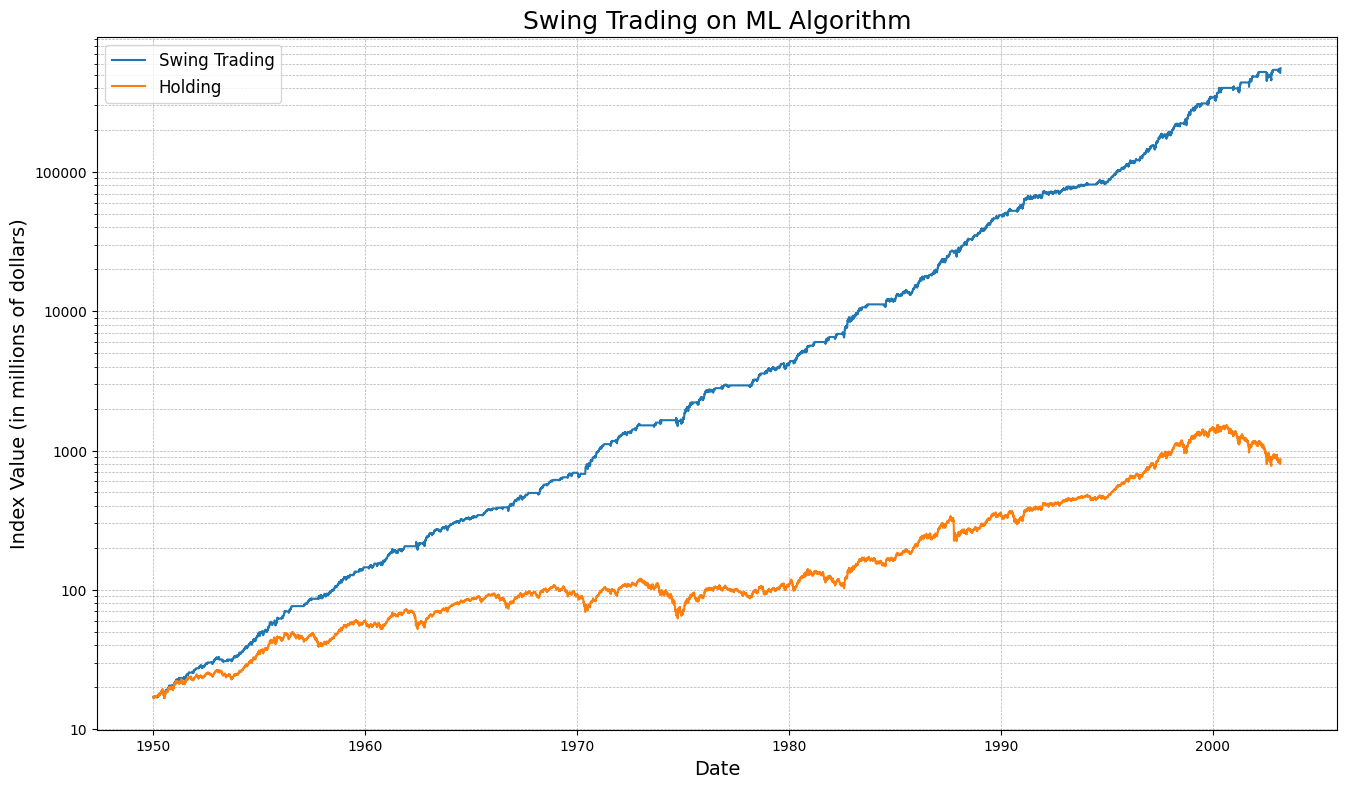

In [105]:
fig, ax = plt.subplots(figsize=(16,9))
plt.plot(new_gspc['Date'],cash_record, label='Swing Trading')
plt.plot(new_gspc['Date'],new_gspc['GSPC.Close'],label='Holding')
ax.set_title('Swing Trading on ML Algorithm', fontsize=18)
ax.set_yscale('log')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Index Value (in millions of dollars)', fontsize=14)
ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())
ax.grid(which='both', linestyle='--', linewidth=0.5)
ax.legend(fontsize=12)
plt.show()

And then on a linear scale. ***for fun***

ValueError: x and y must have same first dimension, but have shapes (24312,) and (13385,)

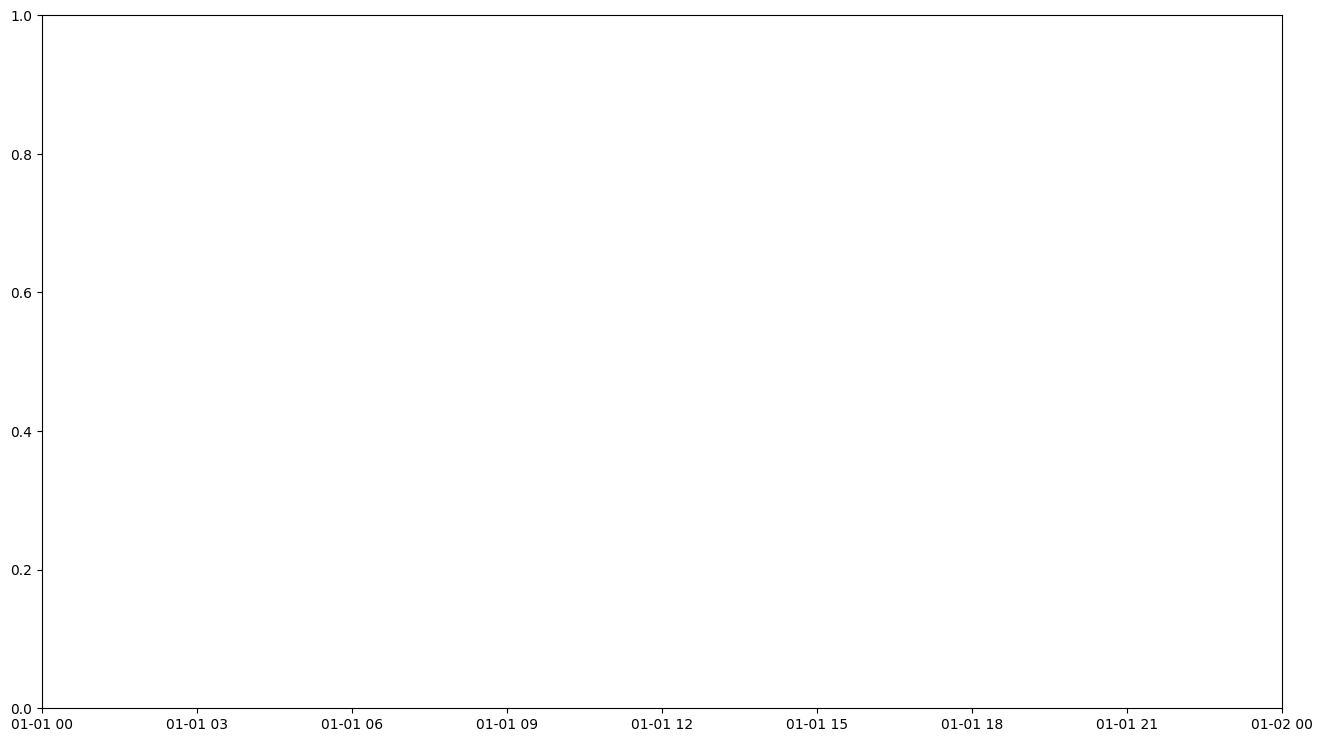

In [106]:
fig, ax = plt.subplots(figsize=(16,9))
plt.plot(gspc['Date'],cash_record, label='Swing Trading')
plt.plot(gspc['Date'],gspc['GSPC.Close'],label='Holding')
ax.set_title('Swing Trading on ML Algorithm', fontsize=18)
#ax.set_yscale('log')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Index Value (USD)', fontsize=14)
#ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())
ax.grid(which='both', linestyle='--', linewidth=0.5)
ax.legend(fontsize=12)
plt.show()

In the next code block, I simulate trade action where only two trades per calendar month are permitted to mimic my own retirement fund, which follows the S&P 500 and has the same restriction on fund transfers. A counter is maintained which is reset each time the calendar month variable changes, which is assessed daily. If the trade counter hits 2, no more trades are facilitated during that month.

In [ ]:
import datetime
cash = 0
stock = 1
cashinhand = 0
cash_record = []
stock_record = []
counter = 1
month_trades = 0
curr_month = gspc['Date'].iloc[0].month
for i in range(len(gspc)):
  month_of_record = gspc['Date'].iloc[i].month
  if month_of_record != curr_month:
    curr_month = month_of_record
    month_trades = 0
  if gspc['buy'].iloc[i] ==1 and gspc['sell'].iloc[i] ==0 and cashinhand == 1 and month_trades <2:
    cash_record.append(cash)
    stock = cash/gspc['GSPC.Close'].iloc[i]
    stock_record.append(stock)
    cashinhand = 0
    cash = 0
    month_trades += 1
    counter += 1
  elif gspc['sell'].iloc[i] == 1 and gspc['buy'].iloc[i] ==0 and cashinhand == 0 and month_trades <2:
    stock_record.append(stock)
    cash = stock*gspc['GSPC.Close'].iloc[i]
    cash_record.append(cash)
    stock = 0
    cashinhand = 1
    month_trades += 1
    counter += 1
  else:
    if stock == 0:
      stock_record.append(cash/gspc['GSPC.Close'].iloc[i])
      cash_record.append(cash)
    elif cash == 0:
      stock_record.append(stock)
      cash_record.append(stock*gspc['GSPC.Close'].iloc[i])
    else:
      cash_record.append(cash + stock*gspc['GSPC.Close'].iloc[i])
      stock_record.append(stock + cash/gspc['GSPC.Close'].iloc[i])
  i += 1
print(cash, stock, counter)

0 763.9432325014837 345


In [ ]:
cash_record[-5:]

[np.float64(4560236.776325263),
 np.float64(4574010.881363767),
 np.float64(4600183.397746551),
 np.float64(4582697.005298667),
 np.float64(4608395.787495942)]

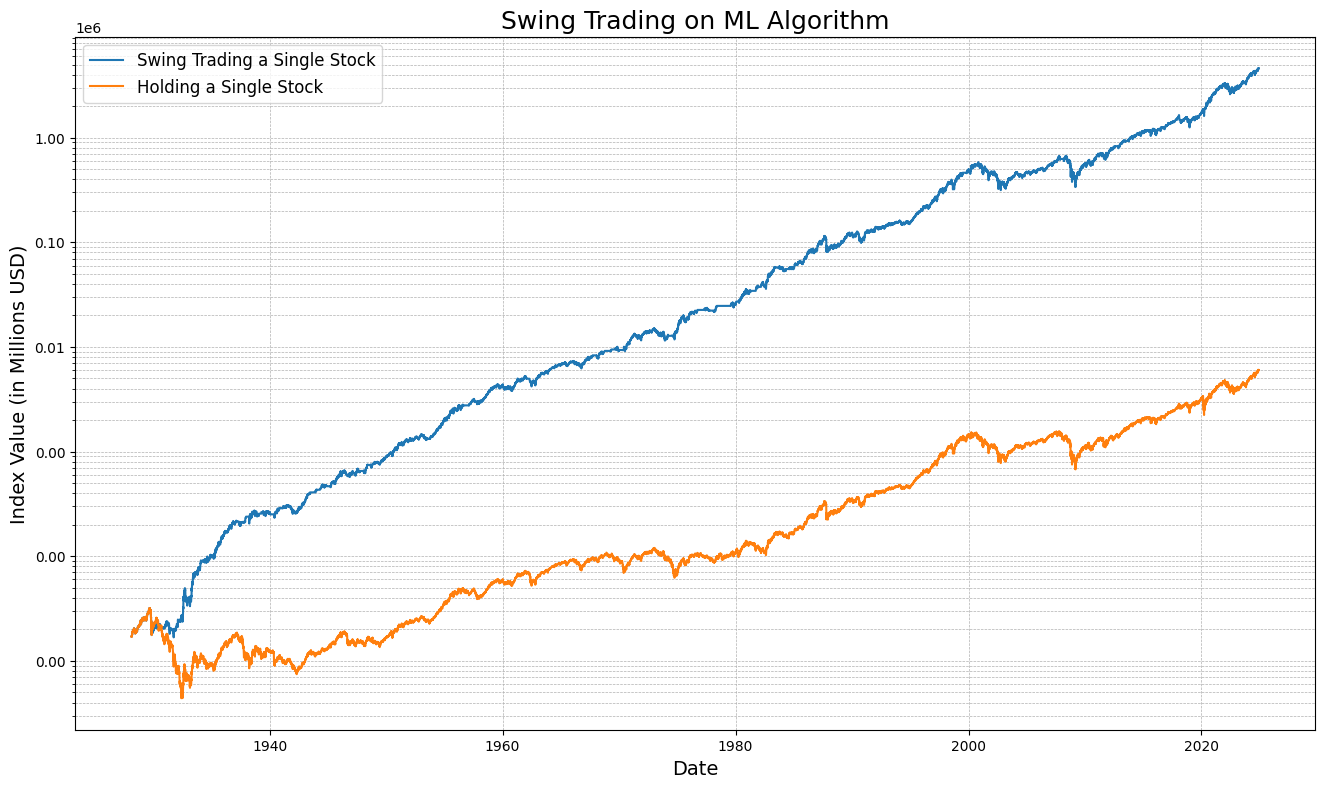

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
plt.plot(gspc['Date'],cash_record, label='Swing Trading a Single Stock')
plt.plot(gspc['Date'],gspc['GSPC.Close'],label='Holding a Single Stock')
ax.set_title('Swing Trading on ML Algorithm', fontsize=18)
ax.set_yscale('log')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Index Value (in Millions USD)', fontsize=14)
ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())
ax.grid(which='both', linestyle='--', linewidth=0.5)
ax.legend(fontsize=12)
plt.show()

Interestingly, the performance actually increased, but not by a notable margin. This seems to show that the frequency of signals are not high enough to impede trade actions on limited accounts.

Next, I will observe the period surrounding the Great Recession and 2008 Housing Crisis to see how the model handles extreme market reactions.

In [ ]:
recessiondf = gspc[20000:21000]
recessiondf.head()

,Date,GSPC.Open,GSPC.High,GSPC.Low,GSPC.Close,GSPC.Volume,GSPC.Adjusted,EMA,SMA,bb_dn,...,macd_buy,macd_sell,ema_buy,ema_sell,risingROC70RSI,fallingROC70RSI,risingROC30RSI,fallingROC30RSI,sell,buy
20000,2007-10-12,1555.410034,1563.030029,1554.089966,1561.800049,2.788690e+09,1561.800049,1535.292710,1535.927502,1494.135546,...,0,0,0,0,0,0,0,0,0,0
20001,2007-10-15,1562.250000,1564.739990,1540.810059,1548.709961,3.139290e+09,1548.709961,1536.570544,1539.530499,1507.521818,...,0,0,0,0,0,0,0,0,0,0
20002,2007-10-16,1547.810059,1547.810059,1536.290039,1538.530029,3.234560e+09,1538.530029,1536.757161,1540.467999,1509.756047,...,0,0,0,0,0,0,0,0,0,0
20003,2007-10-17,1544.439941,1550.660034,1526.010010,1541.239990,3.638070e+09,1541.239990,1537.184097,1541.078497,1510.818178,...,0,0,0,0,0,0,0,0,0,0
20004,2007-10-18,1539.290039,1542.790039,1531.760010,1540.079956,3.203210e+09,1540.079956,1537.459893,1542.144995,1513.655974,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
import datetime
cash = 0
stock = 1
cashinhand = 0
cash_record = []
stock_record = []
counter = 1
month_trades = 0
curr_month = recessiondf['Date'].iloc[0].month
for i in range(len(recessiondf)):
  month_of_record = recessiondf['Date'].iloc[i].month
  if month_of_record != curr_month:
    curr_month = month_of_record
    month_trades = 0
  if recessiondf['buy'].iloc[i] ==1 and recessiondf['sell'].iloc[i] ==0 and cashinhand == 1 and month_trades <2:
    cash_record.append(cash)
    stock = cash/recessiondf['GSPC.Close'].iloc[i]
    stock_record.append(stock)
    cashinhand = 0
    cash = 0
    month_trades += 1
    counter += 1
  elif recessiondf['sell'].iloc[i] == 1 and recessiondf['buy'].iloc[i] ==0 and cashinhand == 0 and month_trades <2:
    stock_record.append(stock)
    cash = stock*recessiondf['GSPC.Close'].iloc[i]
    cash_record.append(cash)
    stock = 0
    cashinhand = 1
    month_trades += 1
    counter += 1
  else:
    if stock == 0:
      stock_record.append(cash/recessiondf['GSPC.Close'].iloc[i])
      cash_record.append(cash)
    elif cash == 0:
      stock_record.append(stock)
      cash_record.append(stock*recessiondf['GSPC.Close'].iloc[i])
  i += 1
print(cash, stock, counter)

0 1.310713113870489 11


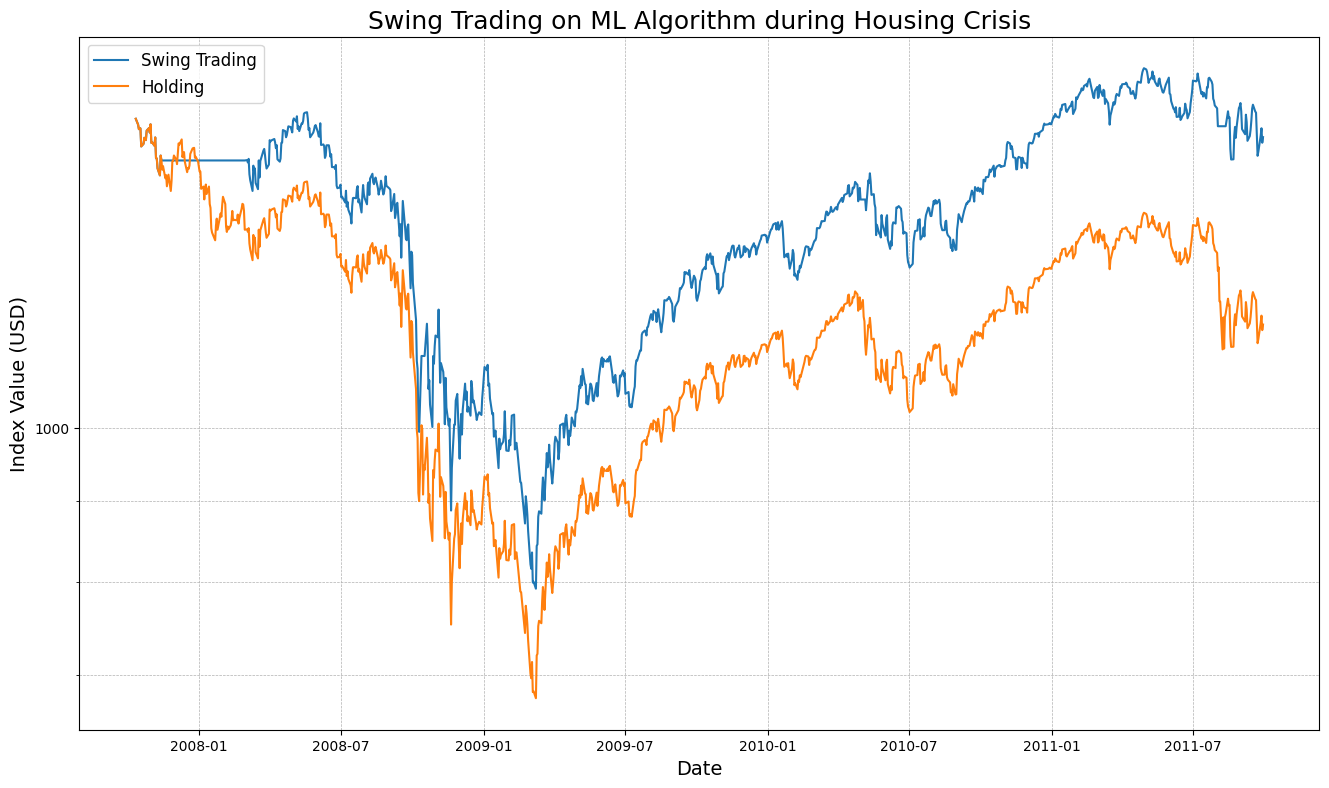

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
plt.plot(recessiondf['Date'],cash_record, label='Swing Trading')
plt.plot(recessiondf['Date'],recessiondf['GSPC.Close'],label='Holding')
ax.set_title('Swing Trading on ML Algorithm during Housing Crisis', fontsize=18)

ax.set_yscale('log')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Index Value (USD)', fontsize=14)
ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())
ax.grid(which='both', linestyle='--', linewidth=0.5)
ax.legend(fontsize=12)
plt.show()

This is a pretty nice success! Not only did we not lose money worse than the market did, but we exceeded the market by 1.7x.

For fun, let's invest in 10% of a stock in the S&P 500 every month we are in it and rerun the simulation from 1927.

In [ ]:
import datetime
cash = 17.04
stock = 0
cashinhand = 1
cash_record = []
stock_record = []
counter = 1
month_trades = 0
curr_month = gspc['Date'].iloc[0].month
for i in range(len(gspc)):
  month_of_record = gspc['Date'].iloc[i].month
  if month_of_record != curr_month:
    curr_month = month_of_record
    month_trades = 0
    cash += gspc['GSPC.Close'].iloc[i]/10
  if (gspc['buy'].iloc[i] ==1) and (gspc['sell'].iloc[i] ==0) and cashinhand == 1 and month_trades <2:
    cash_record.append(cash)
    stock = cash/gspc['GSPC.Close'].iloc[i]
    stock_record.append(stock)
    cashinhand = 0
    cash = 0
    month_trades += 1
    counter += 1
  elif (gspc['sell'].iloc[i] == 1) and (gspc['buy'].iloc[i] ==0) and cashinhand == 0 and month_trades <2:
    stock_record.append(stock)
    cash = stock*gspc['GSPC.Close'].iloc[i]
    cash_record.append(cash)
    stock = 0
    cashinhand = 1
    month_trades += 1
    counter += 1
  else:
    if stock == 0:
      stock_record.append(cash/gspc['GSPC.Close'].iloc[i])
      cash_record.append(cash)
    elif cash == 0:
      stock_record.append(stock)
      cash_record.append(stock*gspc['GSPC.Close'].iloc[i])
    else:
      cash_record.append(cash + stock*gspc['GSPC.Close'].iloc[i])
      stock_record.append(stock + cash/gspc['GSPC.Close'].iloc[i])
  i += 1
pd.options.display.float_format = '{:.2f}'.format
print("Cash Value: %10.0f" % cash_record[len(cash_record)-1].astype(int))
print("Cash Value: %10.2f" % stock_record[len(stock_record)-1].astype(int))

Cash Value:   12659016
Cash Value:    2098.00


That is 7.2 Million dollars.

Looking into the data, the Great Recession hit HARD.

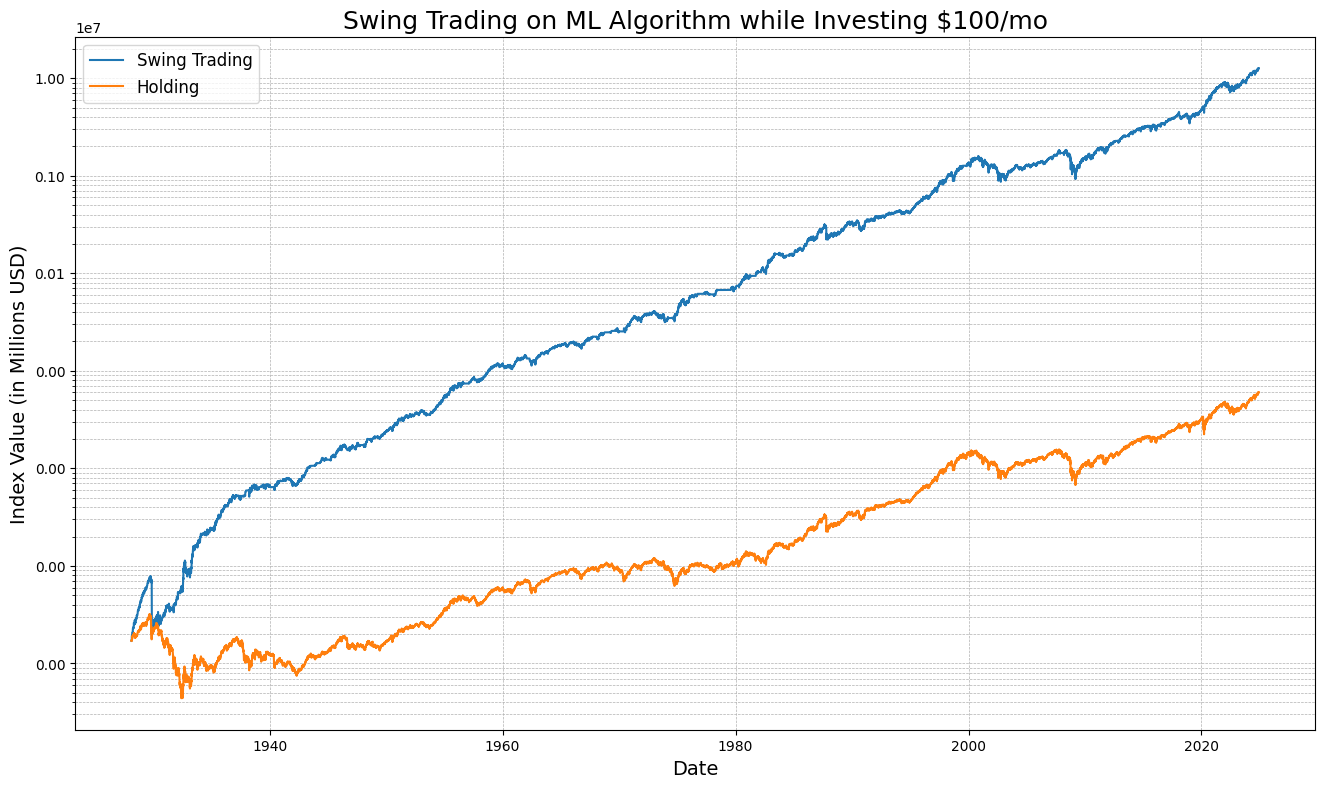

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
plt.plot(gspc['Date'],cash_record, label='Swing Trading')
plt.plot(gspc['Date'],gspc['GSPC.Close'],label='Holding')
ax.set_title('Swing Trading on ML Algorithm while Investing $100/mo', fontsize=18)
ax.set_yscale('log')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Index Value (in Millions USD)', fontsize=14)
ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())
ax.grid(which='both', linestyle='--', linewidth=0.5)
ax.legend(fontsize=12)
plt.show()

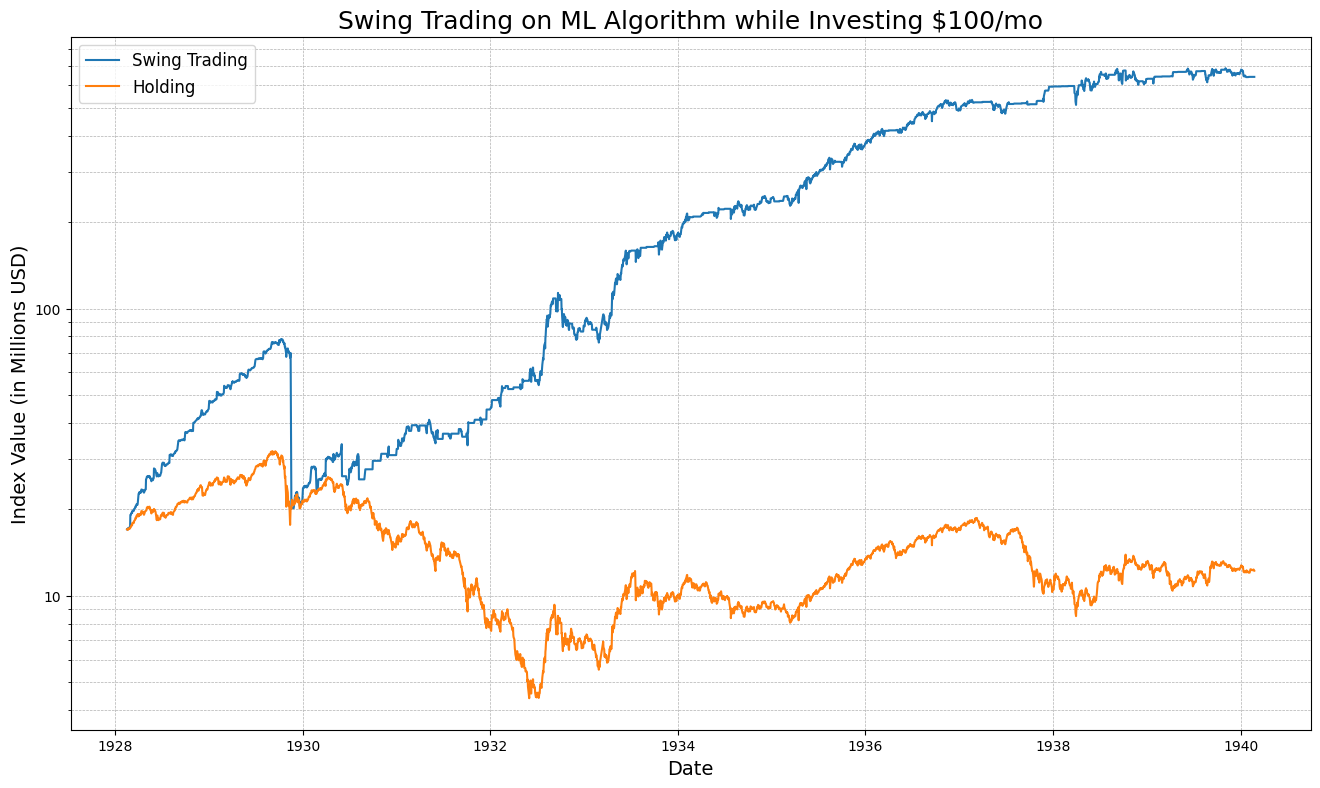

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
plt.plot(gspc['Date'][0:3000],cash_record[0:3000], label='Swing Trading')
plt.plot(gspc['Date'][0:3000],gspc['GSPC.Close'][0:3000],label='Holding')
ax.set_title('Swing Trading on ML Algorithm while Investing $100/mo', fontsize=18)
ax.set_yscale('log')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Index Value (in Millions USD)', fontsize=14)
ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())
ax.grid(which='both', linestyle='--', linewidth=0.5)
ax.legend(fontsize=12)
plt.show()

Now for a realistic test. Let's set a start date of when I began contributing to my funds. And let's put in 400 a month to simulate a ~15 percent income contribution to the fund. How would it perform? Will it outperform holding?

In [ ]:
realistic_history = gspc[22265:]
realistic_history.head()

,Date,GSPC.Open,GSPC.High,GSPC.Low,GSPC.Close,GSPC.Volume,GSPC.Adjusted,EMA,SMA,bb_dn,...,macd_buy,macd_sell,ema_buy,ema_sell,risingROC70RSI,fallingROC70RSI,risingROC30RSI,fallingROC30RSI,sell,buy
22265,2016-10-11,2161.35,2161.56,2128.84,2136.73,3393060000.00,2136.73,2156.92,2153.96,2128.01,...,0,0,0,1,0,0,0,0,0,0
22266,2016-10-12,2137.67,2145.36,2132.77,2139.18,2959510000.00,2139.18,2155.23,2154.63,2131.04,...,0,0,0,0,0,0,0,0,0,0
22267,2016-10-13,2130.26,2138.19,2114.72,2132.55,3538030000.00,2132.55,2153.07,2153.89,2128.58,...,0,0,0,0,0,0,0,0,0,0
22268,2016-10-14,2139.68,2149.19,2132.98,2132.98,3187910000.00,2132.98,2151.15,2153.58,2127.42,...,0,0,0,0,0,0,0,0,0,0
22269,2016-10-17,2132.95,2135.61,2124.43,2126.50,2832440000.00,2126.50,2148.81,2152.95,2124.89,...,0,1,0,0,0,0,0,0,0,0


In [ ]:
cross_check_rh = realistic_history.copy()
cross_check_rh.head()

,Date,GSPC.Open,GSPC.High,GSPC.Low,GSPC.Close,GSPC.Volume,GSPC.Adjusted,EMA,SMA,bb_dn,...,macd_buy,macd_sell,ema_buy,ema_sell,risingROC70RSI,fallingROC70RSI,risingROC30RSI,fallingROC30RSI,sell,buy
22265,2016-10-11,2161.35,2161.56,2128.84,2136.73,3393060000.00,2136.73,2156.92,2153.96,2128.01,...,0,0,0,1,0,0,0,0,0,0
22266,2016-10-12,2137.67,2145.36,2132.77,2139.18,2959510000.00,2139.18,2155.23,2154.63,2131.04,...,0,0,0,0,0,0,0,0,0,0
22267,2016-10-13,2130.26,2138.19,2114.72,2132.55,3538030000.00,2132.55,2153.07,2153.89,2128.58,...,0,0,0,0,0,0,0,0,0,0
22268,2016-10-14,2139.68,2149.19,2132.98,2132.98,3187910000.00,2132.98,2151.15,2153.58,2127.42,...,0,0,0,0,0,0,0,0,0,0
22269,2016-10-17,2132.95,2135.61,2124.43,2126.50,2832440000.00,2126.50,2148.81,2152.95,2124.89,...,0,1,0,0,0,0,0,0,0,0


In [ ]:
import datetime
cash = 0
moneyspent = 2136.73
stock = 1
cashinhand = 0
cash_record = []
stock_record = []
counter = []
month_trades = 0
curr_month = realistic_history['Date'].iloc[0].month
for i in range(len(realistic_history)):
  month_of_record = realistic_history['Date'].iloc[i].month
  if month_of_record != curr_month:
    curr_month = month_of_record
    month_trades = 0
    stock += 400/realistic_history['GSPC.Close'].iloc[i]
    moneyspent += 400
  if (realistic_history['buy'].iloc[i] ==1) and (realistic_history['sell'].iloc[i] ==0) and cashinhand == 1 and month_trades <2:
    cash_record.append(cash)
    stock = cash/realistic_history['GSPC.Close'].iloc[i]
    stock_record.append(stock)
    cashinhand = 0
    cash = 0
    month_trades += 1
    counter.append(cash + stock*realistic_history['GSPC.Close'].iloc[i])
  elif (realistic_history['sell'].iloc[i] == 1) and (realistic_history['buy'].iloc[i] ==0) and cashinhand == 0 and month_trades <2:
    stock_record.append(stock)
    cash = stock*realistic_history['GSPC.Close'].iloc[i]
    cash_record.append(cash)
    stock = 0
    cashinhand = 1
    month_trades += 1
    counter.append(cash + stock*realistic_history['GSPC.Close'].iloc[i])
  else:
    if stock == 0:
      stock_record.append(cash/realistic_history['GSPC.Close'].iloc[i])
      cash_record.append(cash)
      counter.append(0)
    elif cash == 0:
      stock_record.append(stock)
      cash_record.append(stock*realistic_history['GSPC.Close'].iloc[i])
      counter.append(0)
    else:
      cash_record.append(cash + stock*realistic_history['GSPC.Close'].iloc[i])
      stock_record.append(stock + cash/realistic_history['GSPC.Close'].iloc[i])
      counter.append(0)
  i += 1
pd.options.display.float_format = '{:.2f}'.format
print("Cash Value: %10.0f" % cash_record[len(cash_record)-1].astype(int))
print("Stock Value: %10.2f" % stock_record[len(stock_record)-1].astype(float))
print(moneyspent)

Cash Value:      88895
Stock Value:      14.74
40936.729999999996


In [ ]:
import datetime
cash = 0
moneyspent = 2136.73
stock = 1
cashinhand = 0
cash_record2 = []
stock_record2 = []
month_trades = 0
curr_month = cross_check_rh['Date'].iloc[0].month
for i in range(len(cross_check_rh)):
  month_of_record = cross_check_rh['Date'].iloc[i].month
  if month_of_record != curr_month:
    curr_month = month_of_record
    month_trades = 0
    stock += 400/cross_check_rh['GSPC.Close'].iloc[i]
    moneyspent += 400
  cash_record2.append(cash + stock*cross_check_rh['GSPC.Close'].iloc[i])
  stock_record2.append(stock + cash/cross_check_rh['GSPC.Close'].iloc[i])
  i += 1
pd.options.display.float_format = '{:.2f}'.format
print("Cash Value: %10.0f" % cash_record2[len(cash_record2)-1].astype(int))
print("Stock Value: %10.2f" % stock_record2[len(stock_record2)-1].astype(float))
print(moneyspent)

Cash Value:      75744
Stock Value:      12.56
40936.729999999996


In [ ]:
88392/75744

1.1669835234474017

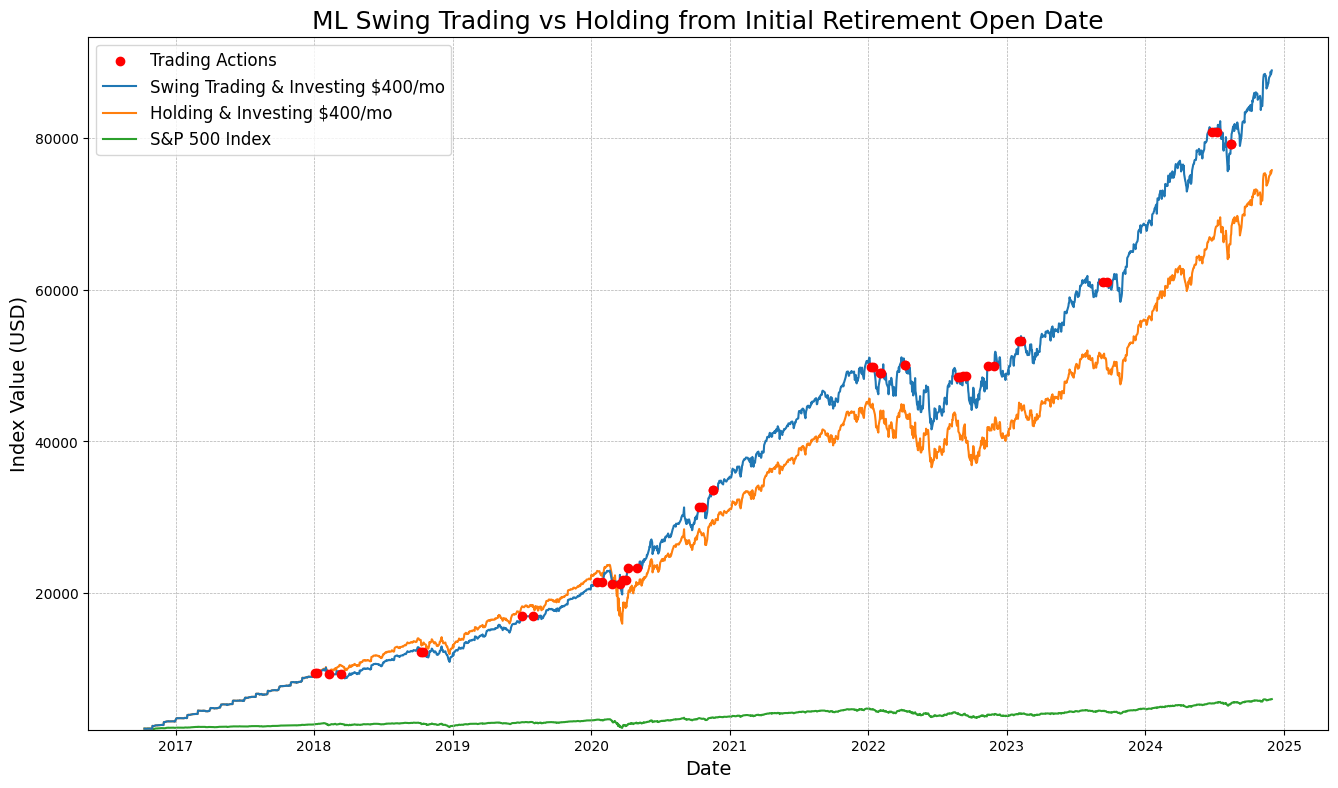

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
plt.scatter(realistic_history['Date'],counter,color='r',label='Trading Actions',zorder=4)
plt.plot(realistic_history['Date'],cash_record, label='Swing Trading & Investing $400/mo',zorder=3)
plt.plot(cross_check_rh['Date'],cash_record2, label='Holding & Investing $400/mo',zorder=2)
plt.plot(realistic_history['Date'],realistic_history['GSPC.Close'],label='S&P 500 Index',zorder=1)
ax.set_title('ML Swing Trading vs Holding from Initial Retirement Open Date', fontsize=18)
#ax.set_yscale('log')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Index Value (USD)', fontsize=14)
#ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())
ax.set_ylim(bottom=2000)
ax.grid(which='both', linestyle='--', linewidth=0.5)
ax.legend(fontsize=12)
plt.show()

So we come to the result that swing trading with this algorithm would have over doubled the money I have put into my retirement account.

In [ ]:
fortyYear_history = gspc[-10400:]
fortyYear_history.head()
cross_check_fh = fortyYear_history.copy()
cross_check_fh

,Date,GSPC.Open,GSPC.High,GSPC.Low,GSPC.Close,GSPC.Volume,GSPC.Adjusted,EMA,SMA,bb_dn,...,macd_buy,macd_sell,ema_buy,ema_sell,risingROC70RSI,fallingROC70RSI,risingROC30RSI,fallingROC30RSI,sell,buy
13913,1983-08-26,160.85,162.16,160.25,162.14,61650000.00,162.14,163.06,162.32,159.40,...,0,0,0,0,0,0,0,0,0,0
13914,1983-08-29,162.14,162.32,160.97,162.25,53030000.00,162.25,162.98,162.33,159.42,...,0,0,0,0,0,0,0,0,0,0
13915,1983-08-30,162.25,163.13,162.11,162.58,62370000.00,162.58,162.95,162.36,159.45,...,1,0,0,0,0,0,0,0,0,0
13916,1983-08-31,162.55,164.40,162.32,164.40,80800000.00,164.40,163.08,162.41,159.40,...,0,0,1,0,0,0,0,0,0,0
13917,1983-09-01,164.40,164.66,163.95,164.23,76120000.00,164.23,163.19,162.55,159.48,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24308,2024-11-22,5944.36,5972.90,5944.36,5969.34,4141420000.00,5969.34,5898.24,5886.69,5696.29,...,0,0,0,0,0,0,0,0,0,0
24309,2024-11-25,5992.28,6020.75,5963.91,5987.37,5633150000.00,5987.37,5906.73,5894.88,5701.97,...,0,0,0,0,0,0,0,0,0,0
24310,2024-11-26,6000.03,6025.42,5992.27,6021.63,3835170000.00,6021.63,5917.67,5904.32,5706.07,...,0,0,0,0,0,0,0,0,0,0
24311,2024-11-27,6014.11,6020.16,5984.87,5998.74,3363340000.00,5998.74,5925.39,5913.57,5715.83,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
import datetime
cash = 0
moneyspent = 2136.73
stock = 1
cashinhand = 0
cash_record = []
stock_record = []
buycounter = []
sellcounter = []
month_trades = 0
curr_month = fortyYear_history['Date'].iloc[0].month
for i in range(len(fortyYear_history)):
  month_of_record = fortyYear_history['Date'].iloc[i].month
  if month_of_record != curr_month:
    curr_month = month_of_record
    month_trades = 0
    stock += 400/fortyYear_history['GSPC.Close'].iloc[i]
    moneyspent += 400
  if (fortyYear_history['buy'].iloc[i] ==1) and (fortyYear_history['sell'].iloc[i] ==0) and cashinhand == 1 and month_trades <2:
    cash_record.append(cash)
    stock = cash/fortyYear_history['GSPC.Close'].iloc[i]
    stock_record.append(stock)
    cashinhand = 0
    cash = 0
    month_trades += 1
    buycounter.append(cash + stock*fortyYear_history['GSPC.Close'].iloc[i])
    sellcounter.append(0)
  elif (fortyYear_history['sell'].iloc[i] == 1) and (fortyYear_history['buy'].iloc[i] ==0) and cashinhand == 0 and month_trades <2:
    stock_record.append(stock)
    cash = stock*fortyYear_history['GSPC.Close'].iloc[i]
    cash_record.append(cash)
    stock = 0
    cashinhand = 1
    month_trades += 1
    sellcounter.append(cash + stock*fortyYear_history['GSPC.Close'].iloc[i])
    buycounter.append(0)
  else:
    if i==0:
      cash_record.append(cash)
      stock_record.append(stock)
      buycounter.append(0)
      sellcounter.append(0)
    elif cash == 0:
      stock_record.append(stock)
      cash_record.append(stock*fortyYear_history['GSPC.Close'].iloc[i])
      buycounter.append(0)
      sellcounter.append(0)
    else:
      cash_record.append(cash_record[-1])
      stock_record.append(stock_record[-1])
      buycounter.append(0)
      sellcounter.append(0)
  i += 1
pd.options.display.float_format = '{:.2f}'.format
print("Cash Value: %10.0f" % cash_record[len(cash_record)-1].astype(int))
print("Stock Value: %10.2f" % stock_record[len(stock_record)-1].astype(float))
print(moneyspent)

Cash Value:    3614654
Stock Value:     599.21
200136.72999999998


In [ ]:
import datetime
cash = 0
moneyspent = 2136.73
stock = 1
cashinhand = 0
cash_record2 = []
stock_record2 = []
month_trades = 0
curr_month = cross_check_fh['Date'].iloc[0].month
for i in range(len(cross_check_fh)):
  month_of_record = cross_check_fh['Date'].iloc[i].month
  if month_of_record != curr_month:
    curr_month = month_of_record
    month_trades = 0
    stock += 400/cross_check_fh['GSPC.Close'].iloc[i]
    moneyspent += 400
  cash_record2.append(cash + stock*cross_check_fh['GSPC.Close'].iloc[i])
  stock_record2.append(stock + cash/cross_check_fh['GSPC.Close'].iloc[i])
  i += 1
pd.options.display.float_format = '{:.2f}'.format
print("Cash Value: %10.0f" % cash_record2[len(cash_record2)-1].astype(int))
print("Stock Value: %10.2f" % stock_record2[len(stock_record2)-1].astype(float))
print(moneyspent)

Cash Value:    1817275
Stock Value:     301.25
200136.72999999998


In [ ]:
5016529/1817275


2.7604677332819745

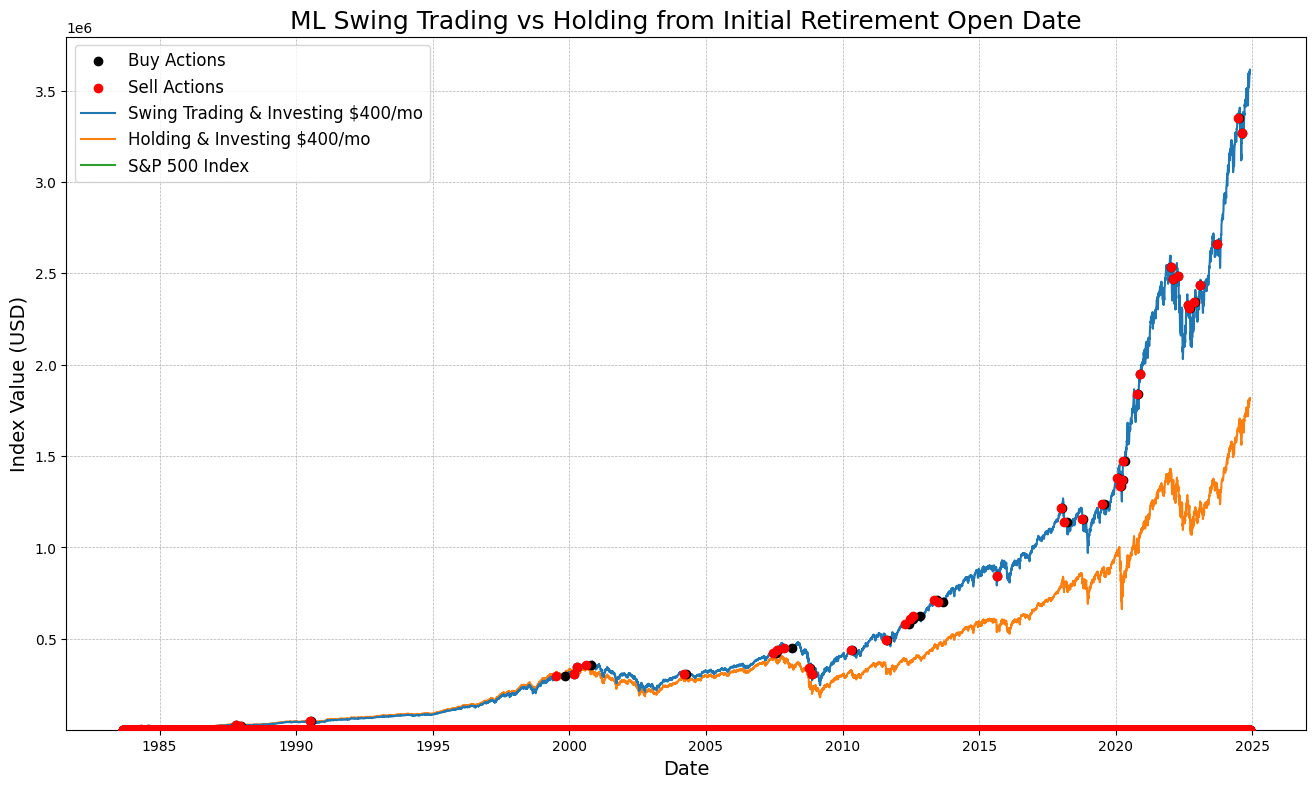

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
plt.scatter(fortyYear_history['Date'],buycounter,color='k',label='Buy Actions',zorder=4)
plt.scatter(fortyYear_history['Date'],sellcounter,color='r',label='Sell Actions',zorder=5)
plt.plot(fortyYear_history['Date'],cash_record, label='Swing Trading & Investing $400/mo',zorder=3)
plt.plot(cross_check_fh['Date'],cash_record2, label='Holding & Investing $400/mo',zorder=2)
plt.plot(fortyYear_history['Date'],fortyYear_history['GSPC.Close'],label='S&P 500 Index',zorder=1)
ax.set_title('ML Swing Trading vs Holding from Initial Retirement Open Date', fontsize=18)
#ax.set_yscale('log')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Index Value (USD)', fontsize=14)
#ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())
ax.set_ylim(bottom=2000)
ax.grid(which='both', linestyle='--', linewidth=0.5)
ax.legend(fontsize=12)
plt.show()

In [ ]:
gspc['nDaysDown'].value_counts()

,count
nDaysDown,
0,19868
1,4445


In [113]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg2 = LinearRegression()
X = new_gspc[['GSPC.Volume','EMA','SMA','bb_dn','bb_mavg','bb_up','bb_pctB','macd','macd_signal','rsi','ema_buy','ema_sell','risingROC70RSI','fallingROC70RSI','risingROC30RSI','fallingROC30RSI','2dayROC','macd_buy','macd_sell','2dayMomentum']]
y = new_gspc['30DaysPercent']*100
X = pd.DataFrame(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
reg.fit(X_train,y_train)
y_pred = reg.predict(X_test)

In [116]:
from sklearn.metrics import mean_squared_error, r2_score
print(mean_squared_error(y_test, y_pred))
print(r2_score(y_test, y_pred))

25.298162408217735
0.006706940031580122


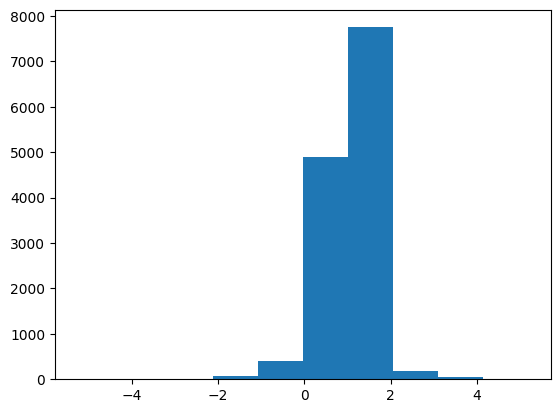

In [108]:
import matplotlib.pyplot as plt
plt.hist(y_pred)
plt.show()

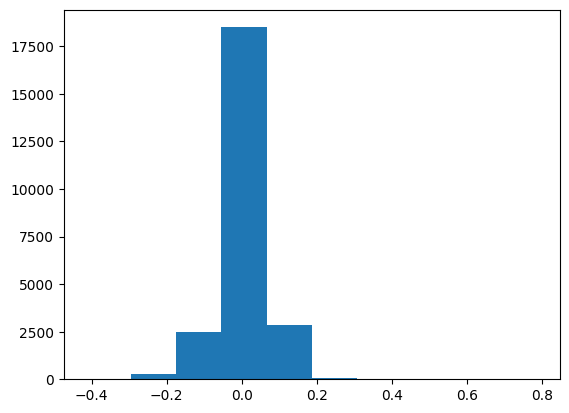

In [109]:
plt.hist(gspc['30DaysPercent'])
plt.show()

Next, let's look at the Thrift Savings Plan's C Fund, which is supposed to follow the S&P 500 to see if the strategy is effective for ETF investiture.

In [ ]:
cfund.head()

,Date,C.Close,Sum.of.S.Fund,Sum.of.G.Fund,Sum.of.I.Fund,EMA,2dM,2dROC,RSI,SMA,MACD_Signal,MACD
0,31-May-03,10.00,10.00,10.00,10.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2-Jun-03,10.03,10.05,10.00,10.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3-Jun-03,10.08,10.04,10.00,10.12,NaN,0.08,0.01,NaN,NaN,NaN,NaN
3,4-Jun-03,10.23,10.20,10.00,10.18,NaN,0.20,0.02,NaN,NaN,NaN,NaN
4,5-Jun-03,10.27,10.30,10.00,10.28,NaN,0.19,0.02,NaN,NaN,NaN,NaN


In [ ]:
cfund.describe()

,C.Close,Sum.of.S.Fund,Sum.of.G.Fund,Sum.of.I.Fund,EMA,2dM,2dROC,RSI,SMA,MACD_Signal,MACD
count,5208.00,5208.00,5208.00,5208.00,5189.00,5206.00,5206.00,5194.00,5189.00,0.00,0.00
mean,29.32,35.59,14.15,24.35,29.26,0.03,0.00,55.40,29.26,NaN,NaN
std,18.85,21.15,2.14,7.58,18.72,0.52,0.02,11.24,18.72,NaN,NaN
min,7.87,9.06,10.00,10.00,8.63,-5.89,-0.15,16.71,8.57,NaN,NaN
25%,14.19,17.81,12.57,18.55,14.18,-0.12,-0.01,47.26,14.19,NaN,NaN
50%,22.61,31.29,14.23,24.01,22.54,0.04,0.00,56.62,22.60,NaN,NaN
75%,40.15,50.68,16.01,29.89,39.98,0.20,0.01,63.89,40.03,NaN,NaN
max,82.21,90.81,18.16,42.68,81.06,3.50,0.12,87.11,81.20,NaN,NaN


In [ ]:
## Sentiment, sentiment_data.csv in shared file is utilized
## 576 days without sentiment score between 2009-07-27 & 2020-06-11
## sentiment_df only has aggregated score daily, sentiment_percentages has daily headline percentage
## negative:0, neutral:1, positive:2

import pandas as pd

sent_path =  "/content/drive/My Drive/DAT490 Working Folder/Main model working folder/sentiment_data.csv"

sentiment = pd.read_csv(sent_path, parse_dates=["Date"])
sentiment['Date'] = pd.to_datetime(sentiment['Date'])
sentiment['Date'] = sentiment['Date'].dt.tz_localize(None)
sentiment['Date'] = pd.to_datetime(sentiment['Date']).dt.tz_localize(None).dt.normalize()
sentiment_df = sentiment[['Date','sentiment_encoded']]

sentiment_df["sentiment_encoded"] = sentiment_df["sentiment_encoded"] - 1.0

sentiment_counts = sentiment.groupby(['Date', 'sentiment_encoded']).size().unstack(fill_value=0)
sentiment_counts['total'] = sentiment_counts.sum(axis=1)
sentiment_percentages = sentiment_counts.div(sentiment_counts['total'], axis=0)
sentiment_percentages = sentiment_percentages.rename(columns={
    'positive': 'positive_pct',
    'negative': 'negative_pct',
    'neutral': 'neutral_pct'
})

sentiment_df = sentiment.groupby("Date")[["sentiment_encoded"]].mean().reset_index()
sentiment_df = sentiment_df.sort_values("Date")

<ipython-input-66-5bea3923b2b4>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiment_df["sentiment_encoded"] = sentiment_df["sentiment_encoded"] - 1.0


In [ ]:
sentiment_df["Date"].min(), sentiment_df["Date"].max()

(Timestamp('2009-07-27 00:00:00'), Timestamp('2020-06-11 00:00:00'))

In [ ]:
sentiment_df.describe()

,Date,sentiment_encoded
count,3396,3396.00
mean,2015-05-26 20:56:23.745583104,1.43
min,2009-07-27 00:00:00,0.00
25%,2012-10-14 12:00:00,1.21
50%,2015-07-12 12:00:00,1.43
75%,2018-02-03 06:00:00,1.70
max,2020-06-11 00:00:00,2.00
std,NaN,0.40


In [ ]:
gspc['Date'].describe()

,Date
count,24313
mean,1976-08-10 18:19:30.040718976
min,1928-02-17 00:00:00
25%,1952-06-19 00:00:00
50%,1976-09-14 00:00:00
75%,2000-10-02 00:00:00
max,2024-11-29 00:00:00


In [ ]:
sentiment_df['sentiment_encoded'] = sentiment_df['sentiment_encoded'].fillna(method='ffill')

<ipython-input-70-5bd3017c3b02>:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sentiment_df['sentiment_encoded'] = sentiment_df['sentiment_encoded'].fillna(method='ffill')


In [ ]:
# macroeconomic trends (CPI, etc.)
!pip install fredapi

from fredapi import Fred
fred = Fred(api_key='dab4815a04eb85f8ef19813a52a64180')

# Retrieve data
cpi = fred.get_series('CPIAUCSL')               # Consumer Price Index
unemployment = fred.get_series('UNEMPLOY')      # Unemployment Rate
interest_rate = fred.get_series('FEDFUNDS')     # Federal Funds Rate
oil_price = fred.get_series('DCOILWTICO')       # West Texas Intermediate Crude
egg_price = fred.get_series('APU0000708111')    # Average price: eggs
unemployment_rate = fred.get_series('UNRATE')   # U.S. Unemployment Rate
gdp_growth = fred.get_series('A191RL1Q225SBEA') # Real GDP (percent change)
treasury_yield_10y = fred.get_series('DGS10')   # Treasury Yield (10-Year)
gold_price = fred.get_series('IR14270')         # Gold Price (Daily from IMF)
usd_index = fred.get_series('DTWEXBGS')         # U.S. Dollar Index (Nominal Broad)



# Combine into a DataFrame
macroindicators_df = pd.DataFrame({
    'CPI': cpi,
    'Unemployment Rate': unemployment,
    'Federal Funds Rate': interest_rate,
    'Oil Price': oil_price,
    'Egg Price': egg_price,
    'Unemployment Rate': unemployment_rate,
    'Real GDP Growth': gdp_growth,
    'Treasury Yield (10-Year)': treasury_yield_10y,
    'Gold Price': gold_price,
    'U.S. Dollar Index': usd_index

})

# Display the first few rows
print(macroindicators_df.head())

             CPI  Unemployment Rate  Federal Funds Rate  Oil Price  Egg Price  \
1947-01-01 21.48                NaN                 NaN        NaN        NaN   
1947-02-01 21.62                NaN                 NaN        NaN        NaN   
1947-03-01 22.00                NaN                 NaN        NaN        NaN   
1947-04-01 22.00                NaN                 NaN        NaN        NaN   
1947-05-01 21.95                NaN                 NaN        NaN        NaN   

            Real GDP Growth  Treasury Yield (10-Year)  Gold Price  \
1947-01-01              NaN                       NaN         NaN   
1947-02-01              NaN                       NaN         NaN   
1947-03-01              NaN                       NaN         NaN   
1947-04-01            -1.00                       NaN         NaN   
1947-05-01              NaN                       NaN         NaN   

            U.S. Dollar Index  
1947-01-01                NaN  
1947-02-01                NaN  
19

In [ ]:
macroindicators_df.tail()

,CPI,Unemployment Rate,Federal Funds Rate,Oil Price,Egg Price,Real GDP Growth,Treasury Yield (10-Year),Gold Price,U.S. Dollar Index
2025-04-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,123.34
2025-04-21,NaN,NaN,NaN,63.48,NaN,NaN,4.42,NaN,NaN
2025-04-22,NaN,NaN,NaN,NaN,NaN,NaN,4.41,NaN,NaN
2025-04-23,NaN,NaN,NaN,NaN,NaN,NaN,4.40,NaN,NaN
2025-04-24,NaN,NaN,NaN,NaN,NaN,NaN,4.32,NaN,NaN


In [ ]:
macroindicators_df = macroindicators_df.reset_index()
macroindicators_df = macroindicators_df.rename(columns={'index':'Date'})

In [ ]:
#gspc['Date'] = pd.to_datetime(gspc['Date']).dt.tz_localize(None).dt.normalize()

In [ ]:
gspc.head()

,Date,GSPC.Open,GSPC.High,GSPC.Low,GSPC.Close,GSPC.Volume,GSPC.Adjusted,EMA,SMA,bb_dn,...,macd_buy,macd_sell,ema_buy,ema_sell,risingROC70RSI,fallingROC70RSI,risingROC30RSI,fallingROC30RSI,sell,buy
0,1928-02-17,17.04,17.04,17.04,17.04,0.00,17.04,17.44,17.50,17.21,...,0,0,0,0,0,0,0,0,0,0
1,1928-02-20,16.95,16.95,16.95,16.95,0.00,16.95,17.39,17.47,17.10,...,0,0,0,0,0,0,0,0,0,1
2,1928-02-21,17.11,17.11,17.11,17.11,0.00,17.11,17.37,17.45,17.05,...,0,0,0,0,0,0,0,0,0,0
3,1928-02-23,17.13,17.13,17.13,17.13,0.00,17.13,17.34,17.42,17.02,...,0,0,0,0,0,0,0,0,0,0
4,1928-02-24,17.18,17.18,17.18,17.18,0.00,17.18,17.33,17.40,16.99,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
merged_df = pd.merge(gspc, sentiment_df,how='inner' , on='Date')

In [ ]:
merged_df.describe()

,Date,GSPC.Open,GSPC.High,GSPC.Low,GSPC.Close,GSPC.Volume,GSPC.Adjusted,EMA,SMA,bb_dn,...,macd_sell,ema_buy,ema_sell,risingROC70RSI,fallingROC70RSI,risingROC30RSI,fallingROC30RSI,sell,buy,sentiment_encoded
count,2658,2658.00,2658.00,2658.00,2658.00,2658.00,2658.00,2658.00,2658.00,2658.00,...,2658.00,2658.00,2658.00,2658.00,2658.00,2658.00,2658.00,2658.00,2658.00,2658.00
mean,2015-02-22 19:32:22.212189696,1992.42,2002.43,1981.55,1992.83,3813343788.56,1992.83,1985.73,1985.61,1928.34,...,0.02,0.06,0.07,0.08,0.01,0.00,0.02,0.01,0.07,1.38
min,2009-07-27 00:00:00,978.63,982.49,972.29,979.73,1030000000.00,979.73,937.58,925.28,858.69,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,2012-06-26 06:00:00,1378.73,1388.91,1371.25,1379.45,3267397500.00,1379.45,1381.72,1380.20,1341.12,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.19
50%,2015-03-03 12:00:00,2003.86,2018.29,1992.90,2002.47,3640845000.00,2002.47,1993.76,1996.30,1948.44,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.38
75%,2017-10-18 18:00:00,2502.21,2520.08,2492.31,2506.80,4146312500.00,2506.80,2536.87,2521.75,2420.33,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.57
max,2020-06-11 00:00:00,3380.45,3393.52,3378.83,3386.15,10617810000.00,3386.15,3334.70,3323.17,3231.29,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,2.00
std,NaN,622.28,624.37,619.73,622.06,940291768.33,622.06,619.45,619.75,602.84,...,0.14,0.24,0.25,0.27,0.08,0.03,0.12,0.09,0.26,0.33


In [ ]:
merged_df.head()

,Date,GSPC.Open,GSPC.High,GSPC.Low,GSPC.Close,GSPC.Volume,GSPC.Adjusted,EMA,SMA,bb_dn,...,macd_sell,ema_buy,ema_sell,risingROC70RSI,fallingROC70RSI,risingROC30RSI,fallingROC30RSI,sell,buy,sentiment_encoded
0,2009-07-27,978.63,982.49,972.29,982.18,4631290000.00,982.18,937.58,925.28,858.69,...,0,0,0,1,0,0,0,0,0,2.00
1,2009-08-07,999.83,1018.00,999.83,1010.48,6827090000.00,1010.48,972.70,968.29,905.77,...,0,0,0,1,0,0,0,0,1,2.00
2,2009-08-10,1008.89,1010.12,1000.99,1007.10,5406080000.00,1007.10,975.98,973.59,917.08,...,0,0,0,1,0,0,0,0,0,1.00
3,2009-08-12,994.00,1012.78,993.36,1005.81,5498170000.00,1005.81,980.40,981.67,937.25,...,0,0,0,0,0,0,0,0,0,2.00
4,2009-08-13,1005.86,1013.14,1000.82,1012.73,5250660000.00,1012.73,983.48,985.27,943.09,...,0,0,0,0,0,0,0,0,0,1.00


In [ ]:
merged_df['sentiment_encoded'] = merged_df['sentiment_encoded'].shift(1)

***Training set - pre-2004***

In [ ]:
gspc['Date'].iloc[19000:]

,Date
19000,2003-10-22
19001,2003-10-23
19002,2003-10-24
19003,2003-10-27
19004,2003-10-28
...,...
24308,2024-11-22
24309,2024-11-25
24310,2024-11-26
24311,2024-11-27


In [ ]:
training_gspc = gspc[0:19000].copy()
testing_gspc = gspc[19000:].copy()

In [ ]:
testing_gspc.columns

Index(['Date', 'GSPC.Open', 'GSPC.High', 'GSPC.Low', 'GSPC.Close',
       'GSPC.Volume', 'GSPC.Adjusted', 'EMA', 'SMA', 'bb_dn', 'bb_mavg',
       'bb_up', 'bb_pctB', '2dayMomentum', '2dayROC', 'macd', 'macd_signal',
       'rsi', '3DaysOutcome', '3DaysPercent', '10DaysOutcome', '10DaysPercent',
       '20DaysOutcome', '20DaysPercent', '30DaysOutcome', '30DaysPercent',
       '45DaysOutcome', '45DaysPercent', '60DaysOutcome', '60DaysPercent',
       'nDaysDown', 'nDaysUp', 'nDaysPos', 'nDaysNeg', 'macd_buy', 'macd_sell',
       'ema_buy', 'ema_sell', 'risingROC70RSI', 'fallingROC70RSI',
       'risingROC30RSI', 'fallingROC30RSI', 'sell', 'buy'],
      dtype='object')

In [ ]:
X = training_gspc[['ema_buy','ema_sell','risingROC70RSI','fallingROC70RSI','risingROC30RSI','fallingROC30RSI','2dayROC','macd_buy','macd_sell','2dayMomentum']]
y = training_gspc['nDaysDown']
yup = training_gspc['nDaysUp']
X2 = testing_gspc[['ema_buy','ema_sell','risingROC70RSI','fallingROC70RSI','risingROC30RSI','fallingROC30RSI','2dayROC','macd_buy','macd_sell','2dayMomentum']]
y2 = testing_gspc['nDaysDown']
y2up = testing_gspc['nDaysUp']
ypos = testing_gspc['nDaysPos']
yneg = testing_gspc['nDaysNeg']
#
X = pd.DataFrame(X)
y = pd.DataFrame(y)
yup = pd.DataFrame(yup)
X2 = pd.DataFrame(X2)
y2 = pd.DataFrame(y2)
y2up = pd.DataFrame(y2up)
#

classifier = XGBClassifier()
classifier2 = XGBClassifier()
classifier.fit(X, y) #looking for down
classifier2.fit(X, yup) #looking for up
y_pred = classifier.predict(X)
y_pred2 = classifier2.predict(X)

In [ ]:
testing_gspc.head()

,Date,GSPC.Open,GSPC.High,GSPC.Low,GSPC.Close,GSPC.Volume,GSPC.Adjusted,EMA,SMA,bb_dn,...,macd_buy,macd_sell,ema_buy,ema_sell,risingROC70RSI,fallingROC70RSI,risingROC30RSI,fallingROC30RSI,sell,buy
19000,2003-10-22,1046.03,1046.03,1028.39,1030.36,1647200000.00,1030.36,1034.46,1030.36,996.10,...,0,0,0,1,0,0,0,0,0,0
19001,2003-10-23,1030.36,1035.44,1025.89,1033.77,1604300000.00,1033.77,1034.39,1031.88,999.94,...,0,0,0,0,0,0,0,0,0,1
19002,2003-10-24,1033.77,1033.77,1018.32,1028.91,1420300000.00,1028.91,1033.87,1033.49,1005.81,...,0,0,0,0,0,0,0,0,0,0
19003,2003-10-27,1028.91,1037.75,1028.91,1031.13,1371800000.00,1031.13,1033.61,1034.72,1009.89,...,0,0,0,0,0,0,0,0,0,0
19004,2003-10-28,1031.13,1046.79,1031.13,1046.79,1629200000.00,1046.79,1034.87,1037.26,1019.38,...,0,0,1,0,0,0,0,0,0,0


In [ ]:
testing_gspc.columns

Index(['Date', 'GSPC.Open', 'GSPC.High', 'GSPC.Low', 'GSPC.Close',
       'GSPC.Volume', 'GSPC.Adjusted', 'EMA', 'SMA', 'bb_dn', 'bb_mavg',
       'bb_up', 'bb_pctB', '2dayMomentum', '2dayROC', 'macd', 'macd_signal',
       'rsi', '3DaysOutcome', '3DaysPercent', '10DaysOutcome', '10DaysPercent',
       '20DaysOutcome', '20DaysPercent', '30DaysOutcome', '30DaysPercent',
       '45DaysOutcome', '45DaysPercent', '60DaysOutcome', '60DaysPercent',
       'nDaysDown', 'nDaysUp', 'nDaysPos', 'nDaysNeg', 'macd_buy', 'macd_sell',
       'ema_buy', 'ema_sell', 'risingROC70RSI', 'fallingROC70RSI',
       'risingROC30RSI', 'fallingROC30RSI', 'sell', 'buy'],
      dtype='object')

In [ ]:
testing_sell = classifier.predict(X2)
testing_buy = classifier2.predict(X2)

In [ ]:
testing_gspc['buy'] = testing_buy
testing_gspc['sell'] = testing_sell

In [ ]:
cm = confusion_matrix(yneg, testing_sell)
print(cm)

[[2535  983]
 [1329  466]]


In [ ]:
cm = confusion_matrix(ypos, testing_buy)
print(cm)


[[1718   77]
 [3374  144]]


In [ ]:
import datetime
cash = 0
moneyspent = 1030.36
stock = 1
cashinhand = 0
cash_record = []
stock_record = []
buycounter = []
sellcounter = []
month_trades = 0
curr_month = testing_gspc['Date'].iloc[0].month
for i in range(len(testing_gspc)):
  month_of_record = testing_gspc['Date'].iloc[i].month
  if month_of_record != curr_month:
    curr_month = month_of_record
    month_trades = 0
    stock += 400/testing_gspc['GSPC.Close'].iloc[i]
    moneyspent += 400
  if (testing_gspc['buy'].iloc[i] ==1) and (testing_gspc['sell'].iloc[i] ==0) and cashinhand == 1 and month_trades <2:
    cash_record.append(cash)
    stock = cash/testing_gspc['GSPC.Close'].iloc[i]
    stock_record.append(stock)
    cashinhand = 0
    cash = 0
    month_trades += 1
    buycounter.append(cash + stock*testing_gspc['GSPC.Close'].iloc[i])
    sellcounter.append(0)
  elif (testing_gspc['sell'].iloc[i] == 1) and (testing_gspc['buy'].iloc[i] ==0) and cashinhand == 0 and month_trades <2:
    stock_record.append(stock)
    cash = stock*testing_gspc['GSPC.Close'].iloc[i]
    cash_record.append(cash)
    stock = 0
    cashinhand = 1
    month_trades += 1
    sellcounter.append(cash + stock*testing_gspc['GSPC.Close'].iloc[i])
    buycounter.append(0)
  else:
    if i==0:
      cash_record.append(cash)
      stock_record.append(stock)
      buycounter.append(0)
      sellcounter.append(0)
    elif cash == 0:
      stock_record.append(stock)
      cash_record.append(stock*testing_gspc['GSPC.Close'].iloc[i])
      buycounter.append(0)
      sellcounter.append(0)
    else:
      cash_record.append(cash_record[-1])
      stock_record.append(stock_record[-1])
      buycounter.append(0)
      sellcounter.append(0)
  i += 1
pd.options.display.float_format = '{:.2f}'.format
print("Cash Value: %10.0f" % cash_record[len(cash_record)-1].astype(int))
print("Stock Value: %10.2f" % stock_record[len(stock_record)-1].astype(float))
print(moneyspent)

Cash Value:      28473
Stock Value:       7.57
102230.36


In [ ]:
import datetime
cash = 0
moneyspent = 1030.36
stock = 1
cashinhand = 0
cash_record2 = []
stock_record2 = []
month_trades = 0
curr_month = testing_gspc['Date'].iloc[0].month
for i in range(len(testing_gspc)):
  month_of_record = testing_gspc['Date'].iloc[i].month
  if month_of_record != curr_month:
    curr_month = month_of_record
    month_trades = 0
    stock += 400/testing_gspc['GSPC.Close'].iloc[i]
    moneyspent += 400
  cash_record2.append(cash + stock*testing_gspc['GSPC.Close'].iloc[i])
  stock_record2.append(stock + cash/testing_gspc['GSPC.Close'].iloc[i])
  i += 1
pd.options.display.float_format = '{:.2f}'.format
print("Cash Value: %10.0f" % cash_record2[len(cash_record2)-1].astype(int))
print("Stock Value: %10.2f" % stock_record2[len(stock_record2)-1].astype(float))
print(moneyspent)

Cash Value:     355128
Stock Value:      58.87
102230.36


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
classifier2 = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
classifier.fit(X, np.ravel(y,order='C'))
classifier2.fit(X, np.ravel(yup,order='C'))
y_pred = classifier.predict(X)
y_pred2 = classifier2.predict(X)

In [ ]:
testing_sell = classifier.predict(X2)
testing_buy = classifier2.predict(X2)

In [ ]:
testing_gspc['buy'] = testing_buy
testing_gspc['sell'] = testing_sell

In [ ]:
cm = confusion_matrix(y2, testing_sell)
print(cm)

[[4227  329]
 [ 693   64]]


In [ ]:
cm = confusion_matrix(y2, testing_buy)
print(cm)

[[3514 1042]
 [ 570  187]]


In [ ]:
import datetime
cash = 0
moneyspent = 1030.36
stock = 1
cashinhand = 0
cash_record = []
stock_record = []
buycounter = []
sellcounter = []
month_trades = 0
curr_month = testing_gspc['Date'].iloc[0].month
for i in range(len(testing_gspc)):
  month_of_record = testing_gspc['Date'].iloc[i].month
  if month_of_record != curr_month:
    curr_month = month_of_record
    month_trades = 0
    stock += 400/testing_gspc['GSPC.Close'].iloc[i]
    moneyspent += 400
  if (testing_gspc['buy'].iloc[i] ==1) and (testing_gspc['sell'].iloc[i] ==0) and cashinhand == 1 and month_trades <2:
    cash_record.append(cash)
    stock = cash/testing_gspc['GSPC.Close'].iloc[i]
    stock_record.append(stock)
    cashinhand = 0
    cash = 0
    month_trades += 1
    buycounter.append(cash + stock*testing_gspc['GSPC.Close'].iloc[i])
    sellcounter.append(0)
  elif (testing_gspc['sell'].iloc[i] == 1) and (testing_gspc['buy'].iloc[i] ==0) and cashinhand == 0 and month_trades <2:
    stock_record.append(stock)
    cash = stock*testing_gspc['GSPC.Close'].iloc[i]
    cash_record.append(cash)
    stock = 0
    cashinhand = 1
    month_trades += 1
    sellcounter.append(cash + stock*testing_gspc['GSPC.Close'].iloc[i])
    buycounter.append(0)
  else:
    if i==0:
      cash_record.append(cash)
      stock_record.append(stock)
      buycounter.append(0)
      sellcounter.append(0)
    elif cash == 0:
      stock_record.append(stock)
      cash_record.append(stock*testing_gspc['GSPC.Close'].iloc[i])
      buycounter.append(0)
      sellcounter.append(0)
    else:
      cash_record.append(cash_record[-1])
      stock_record.append(stock_record[-1])
      buycounter.append(0)
      sellcounter.append(0)
  i += 1
pd.options.display.float_format = '{:.2f}'.format
print("Cash Value: %10.0f" % cash_record[len(cash_record)-1].astype(int))
print("Stock Value: %10.2f" % stock_record[len(stock_record)-1].astype(float))
print(moneyspent)

Cash Value:     149440
Stock Value:      24.96
102230.36


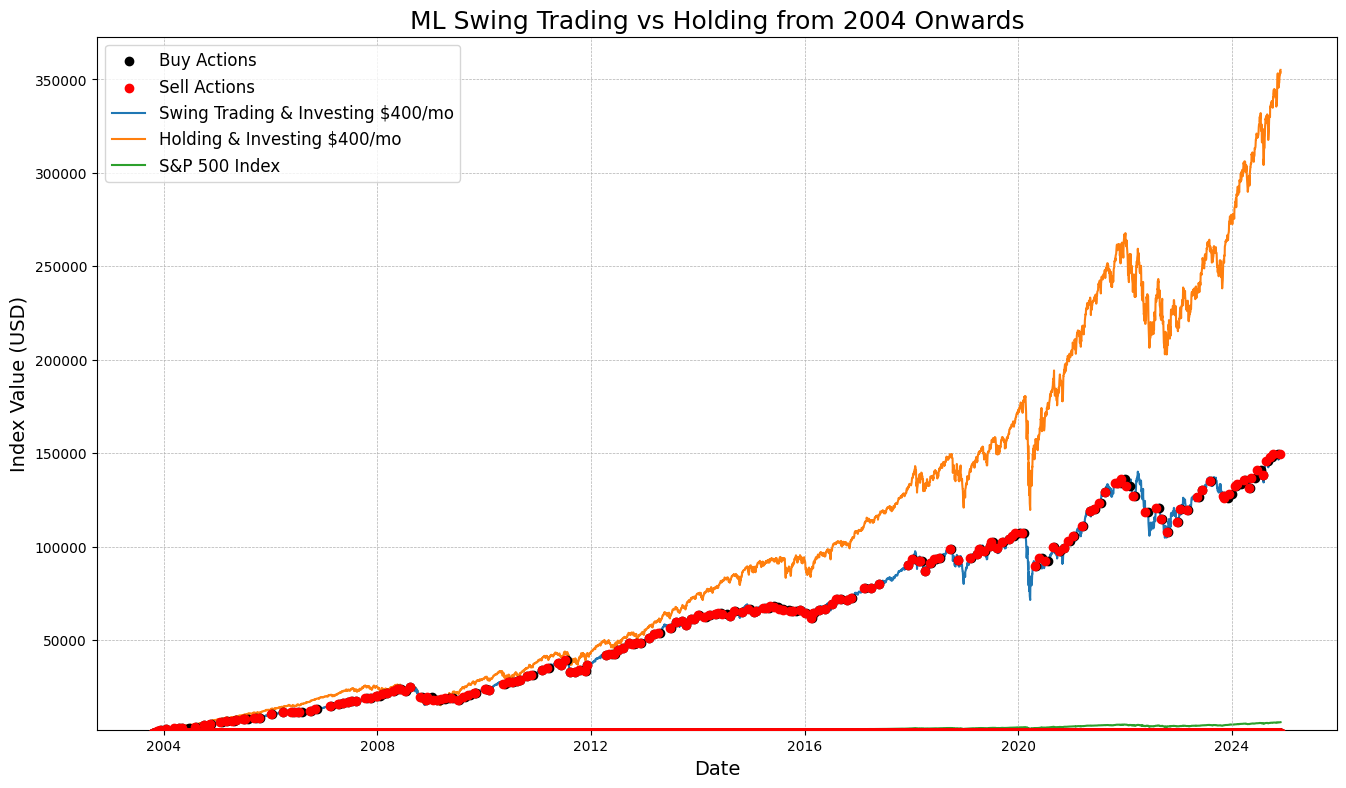

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
plt.scatter(testing_gspc['Date'],buycounter,color='k',label='Buy Actions',zorder=4)
plt.scatter(testing_gspc['Date'],sellcounter,color='r',label='Sell Actions',zorder=5)
plt.plot(testing_gspc['Date'],cash_record, label='Swing Trading & Investing $400/mo',zorder=3)
plt.plot(testing_gspc['Date'],cash_record2, label='Holding & Investing $400/mo',zorder=2)
plt.plot(testing_gspc['Date'],testing_gspc['GSPC.Close'],label='S&P 500 Index',zorder=1)
ax.set_title('ML Swing Trading vs Holding from 2004 Onwards', fontsize=18)
#ax.set_yscale('log')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Index Value (USD)', fontsize=14)
#ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())
ax.set_ylim(bottom=2000)
ax.grid(which='both', linestyle='--', linewidth=0.5)
ax.legend(fontsize=12)
plt.show()

In [ ]:
merged_df.isna().sum(axis=0)

,0
Date,0
GSPC.Open,0
GSPC.High,0
GSPC.Low,0
GSPC.Close,0
GSPC.Volume,0
GSPC.Adjusted,0
EMA,0
SMA,0
bb_dn,0


In [ ]:
merged_df['sentiment_encoded'] = merged_df['sentiment_encoded']-1
merged_df = merged_df.dropna()

In [ ]:
merged_df.head()

,Date,GSPC.Open,GSPC.High,GSPC.Low,GSPC.Close,GSPC.Volume,GSPC.Adjusted,EMA,SMA,bb_dn,...,macd_sell,ema_buy,ema_sell,risingROC70RSI,fallingROC70RSI,risingROC30RSI,fallingROC30RSI,sell,buy,sentiment_encoded
1,2009-08-07,999.83,1018.00,999.83,1010.48,6827090000.00,1010.48,972.70,968.29,905.77,...,0,0,0,1,0,0,0,0,1,1.00
2,2009-08-10,1008.89,1010.12,1000.99,1007.10,5406080000.00,1007.10,975.98,973.59,917.08,...,0,0,0,1,0,0,0,0,0,1.00
3,2009-08-12,994.00,1012.78,993.36,1005.81,5498170000.00,1005.81,980.40,981.67,937.25,...,0,0,0,0,0,0,0,0,0,0.00
4,2009-08-13,1005.86,1013.14,1000.82,1012.73,5250660000.00,1012.73,983.48,985.27,943.09,...,0,0,0,0,0,0,0,0,0,1.00
5,2009-08-17,998.18,998.18,978.51,979.73,4088570000.00,979.73,984.90,989.89,956.20,...,0,0,1,0,0,0,0,0,0,0.00


In [ ]:
merged_df.columns

Index(['Date', 'GSPC.Open', 'GSPC.High', 'GSPC.Low', 'GSPC.Close',
       'GSPC.Volume', 'GSPC.Adjusted', 'EMA', 'SMA', 'bb_dn', 'bb_mavg',
       'bb_up', 'bb_pctB', '2dayMomentum', '2dayROC', 'macd', 'macd_signal',
       'rsi', '3DaysOutcome', '3DaysPercent', '10DaysOutcome', '10DaysPercent',
       '20DaysOutcome', '20DaysPercent', '30DaysOutcome', '30DaysPercent',
       '45DaysOutcome', '45DaysPercent', '60DaysOutcome', '60DaysPercent',
       'nDaysDown', 'nDaysUp', 'nDaysPos', 'nDaysNeg', 'macd_buy', 'macd_sell',
       'ema_buy', 'ema_sell', 'risingROC70RSI', 'fallingROC70RSI',
       'risingROC30RSI', 'fallingROC30RSI', 'sell', 'buy',
       'sentiment_encoded'],
      dtype='object')

In [ ]:
len(merged_df)*.8

2125.6

In [ ]:
train_df = merged_df.iloc[0:2100].copy()
test_df = merged_df.iloc[2100:].copy()
test_df.head()

,Date,GSPC.Open,GSPC.High,GSPC.Low,GSPC.Close,GSPC.Volume,GSPC.Adjusted,EMA,SMA,bb_dn,...,macd_sell,ema_buy,ema_sell,risingROC70RSI,fallingROC70RSI,risingROC30RSI,fallingROC30RSI,sell,buy,sentiment_encoded
2101,2018-03-27,2667.57,2674.78,2596.12,2612.62,3761320000.00,2612.62,2697.70,2711.31,2608.04,...,0,0,0,0,0,0,0,0,0,0.44
2102,2018-03-28,2611.30,2632.65,2593.06,2605.00,3875720000.00,2605.00,2688.87,2705.87,2592.71,...,0,0,0,0,0,0,0,0,0,0.43
2103,2018-03-29,2614.41,2659.07,2609.72,2640.87,3572360000.00,2640.87,2684.30,2704.03,2587.93,...,0,0,0,0,0,0,0,0,0,0.38
2104,2018-04-02,2633.45,2638.30,2553.80,2581.88,3635780000.00,2581.88,2674.54,2698.56,2570.85,...,0,0,0,0,0,0,0,0,1,0.00
2105,2018-04-03,2592.17,2619.14,2575.49,2614.45,3395840000.00,2614.45,2668.82,2693.24,2560.91,...,0,0,0,0,0,0,0,0,0,0.43


In [ ]:
train_df = train_df.drop(['sell','buy'],axis=1)
test_df = test_df.drop(['sell','buy'],axis=1)
X = train_df[['ema_buy','ema_sell','risingROC70RSI','fallingROC70RSI','risingROC30RSI','fallingROC30RSI','2dayROC','macd_buy','macd_sell','sentiment_encoded']]
y = train_df['nDaysDown']
yup = train_df['nDaysUp']

X_test = test_df[['ema_buy','ema_sell','risingROC70RSI','fallingROC70RSI','risingROC30RSI','fallingROC30RSI','2dayROC','macd_buy','macd_sell','sentiment_encoded']]
y_test = test_df['nDaysDown']
yup_test = test_df['nDaysUp']

X = pd.DataFrame(X)
y = pd.DataFrame(y)
yup = pd.DataFrame(yup)
X_test = pd.DataFrame(X_test)
y_test = pd.DataFrame(y_test)
yup_test = pd.DataFrame(yup_test)


In [ ]:
knn = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
knn.fit(X, np.ravel(y,order='C'))
y_pred = knn.predict(X)

knn2 = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
knn2.fit(X, np.ravel(yup,order='C'))
y_pred2 = knn.predict(X)

cm = confusion_matrix(y, y_pred)
print(cm)
cm2 = confusion_matrix(yup, y_pred2)
print(cm2)

[[1871    2]
 [ 217   10]]
[[1457   12]
 [ 631    0]]


In [ ]:
testing_sell = knn.predict(X_test)
testing_buy = knn2.predict(X_test)

In [ ]:
cm = confusion_matrix(y_test, testing_sell)
print(cm)
cm2 = confusion_matrix(yup_test, testing_buy)
print(cm2)

[[455   3]
 [ 99   0]]
[[288  46]
 [175  48]]


In [ ]:
classifier = XGBClassifier()
classifier2 = XGBClassifier()
classifier.fit(X, y) #looking for down
classifier2.fit(X, yup) #looking for up
y_pred = classifier.predict(X)
y_pred2 = classifier2.predict(X)
#
testing_sell = classifier.predict(X_test)
testing_buy = classifier2.predict(X_test)
#
cm = confusion_matrix(y_test, testing_sell)
print(cm)
print(accuracy_score(y_test, testing_sell))
cm2 = confusion_matrix(yup_test, testing_buy)
print(cm2)
accuracy_score(y_test, testing_buy)

[[445  13]
 [ 97   2]]
0.8025134649910234
[[292  42]
 [176  47]]


0.7019748653500898

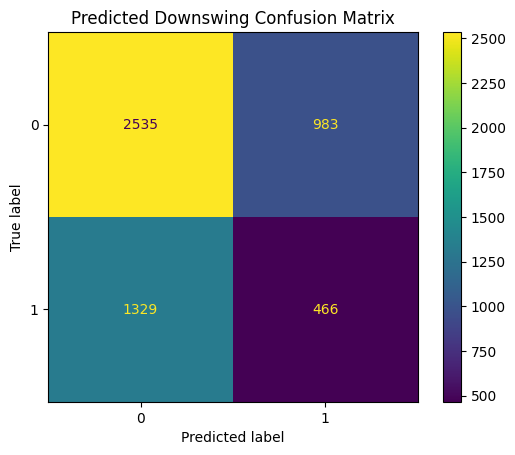

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot()
plt.title('Predicted Downswing Confusion Matrix')
plt.show()

In [ ]:
test_df['buy'] = testing_buy
test_df['sell'] = testing_sell

In [ ]:
test_df.head()

,Date,GSPC.Open,GSPC.High,GSPC.Low,GSPC.Close,GSPC.Volume,GSPC.Adjusted,EMA,SMA,bb_dn,...,macd_sell,ema_buy,ema_sell,risingROC70RSI,fallingROC70RSI,risingROC30RSI,fallingROC30RSI,sentiment_encoded,buy,sell
2101,2018-03-27,2667.57,2674.78,2596.12,2612.62,3761320000.00,2612.62,2697.70,2711.31,2608.04,...,0,0,0,0,0,0,0,0.44,0,0
2102,2018-03-28,2611.30,2632.65,2593.06,2605.00,3875720000.00,2605.00,2688.87,2705.87,2592.71,...,0,0,0,0,0,0,0,0.43,1,0
2103,2018-03-29,2614.41,2659.07,2609.72,2640.87,3572360000.00,2640.87,2684.30,2704.03,2587.93,...,0,0,0,0,0,0,0,0.38,0,0
2104,2018-04-02,2633.45,2638.30,2553.80,2581.88,3635780000.00,2581.88,2674.54,2698.56,2570.85,...,0,0,0,0,0,0,0,0.00,0,0
2105,2018-04-03,2592.17,2619.14,2575.49,2614.45,3395840000.00,2614.45,2668.82,2693.24,2560.91,...,0,0,0,0,0,0,0,0.43,0,1


In [ ]:
import datetime
cash = 0
moneyspent = 2612.62
stock = 1
cashinhand = 0
lastpricebought = 2612.62
lastpricesold = 2612.62
branchcounter = []
cash_record = []
stock_record = []
buycounter = []
sellcounter = []
month_trades = 0
curr_month = test_df['Date'].iloc[0].month
for i in range(len(test_df)):
  month_of_record = test_df['Date'].iloc[i].month
  if month_of_record != curr_month:
    curr_month = month_of_record
    month_trades = 0
  if (test_df['buy'].iloc[i] ==1) and (test_df['sell'].iloc[i] ==0) and cashinhand == 1:
    branchcounter.append(0)
    cash_record.append(cash)
    stock = cash/test_df['GSPC.Close'].iloc[i]
    lastpricebought = test_df['GSPC.Close'].iloc[i]
    lastpricesold = 0
    stock_record.append(stock)
    cashinhand = 0
    cash = 0
    month_trades += 1
    buycounter.append(cash + stock*test_df['GSPC.Close'].iloc[i])
    sellcounter.append(0)
  elif (test_df['sell'].iloc[i] == 1) and (test_df['buy'].iloc[i] ==0) and cashinhand == 0 and (test_df['GSPC.Close'].iloc[i] > lastpricebought):
    branchcounter.append(0)
    stock_record.append(stock)
    cash = stock*test_df['GSPC.Close'].iloc[i]
    lastpricesold = test_df['GSPC.Close'].iloc[i]
    lastpricebought = 0
    cash_record.append(cash)
    stock = 0
    cashinhand = 1
    month_trades += 1
    sellcounter.append(cash + stock*test_df['GSPC.Close'].iloc[i])
    buycounter.append(0)
  else:
    if i==0:
      branchcounter.append(0)
      cash_record.append(cash)
      stock_record.append(stock)
      buycounter.append(0)
      sellcounter.append(0)
    elif lastpricebought>0:
      if test_df['GSPC.Close'].iloc[i] > lastpricebought*1.05:
        branchcounter.append(stock*test_df['GSPC.Close'].iloc[i])
        stock_record.append(stock)
        cash = stock*test_df['GSPC.Close'].iloc[i]
        lastpricesold = test_df['GSPC.Close'].iloc[i]
        lastpricebought = 0
        cash_record.append(cash)
        stock = 0
        cashinhand = 1
        month_trades += 1
        sellcounter.append(cash + stock*test_df['GSPC.Close'].iloc[i])
        buycounter.append(0)
      else:
        branchcounter.append(0)
        stock_record.append(stock)
        cash_record.append(stock*test_df['GSPC.Close'].iloc[i])
        buycounter.append(0)
        sellcounter.append(0)
    else:
      branchcounter.append(0)
      if test_df['GSPC.Close'].iloc[i] < lastpricesold*0.98:
        cash_record.append(cash)
        stock = cash/test_df['GSPC.Close'].iloc[i]
        lastpricebought = test_df['GSPC.Close'].iloc[i]
        lastpricesold = 0
        stock_record.append(stock)
        cashinhand = 0
        cash = 0
        month_trades += 1
        buycounter.append(cash + stock*test_df['GSPC.Close'].iloc[i])
        sellcounter.append(0)
      else:
        cash_record.append(cash_record[-1])
        stock_record.append(stock_record[-1])
        buycounter.append(0)
        sellcounter.append(0)
  i += 1
pd.options.display.float_format = '{:.2f}'.format
print("Cash Value: %10.0f" % cash_record[len(cash_record)-1].astype(int))
print("Stock Value: %10.2f" % stock_record[len(stock_record)-1].astype(float))
print(moneyspent)

Cash Value:       3077
Stock Value:       1.03
2612.62


In [ ]:
len(branchcounter)

557

In [ ]:
import datetime
cash = 0
moneyspent = 1030.36
stock = 1
cashinhand = 0
cash_record2 = []
stock_record2 = []
month_trades = 0
curr_month = test_df['Date'].iloc[0].month
for i in range(len(test_df)):
  month_of_record = test_df['Date'].iloc[i].month
  if month_of_record != curr_month:
    curr_month = month_of_record
    month_trades = 0
  cash_record2.append(cash + stock*test_df['GSPC.Close'].iloc[i])
  stock_record2.append(stock + cash/test_df['GSPC.Close'].iloc[i])
  i += 1
pd.options.display.float_format = '{:.2f}'.format
print("Cash Value: %10.0f" % cash_record2[len(cash_record2)-1].astype(int))
print("Stock Value: %10.2f" % stock_record2[len(stock_record2)-1].astype(float))
print(moneyspent)

Cash Value:       3002
Stock Value:       1.00
1030.36


In [ ]:
len(buycounter)

557

In [ ]:
test_df[130:150]

,Date,GSPC.Open,GSPC.High,GSPC.Low,GSPC.Close,GSPC.Volume,GSPC.Adjusted,EMA,SMA,bb_dn,...,macd_sell,ema_buy,ema_sell,risingROC70RSI,fallingROC70RSI,risingROC30RSI,fallingROC30RSI,sentiment_encoded,buy,sell
2231,2018-10-01,2926.29,2937.06,2917.91,2924.59,3375890000.00,2924.59,2903.74,2902.65,2868.59,...,0,0,0,0,0,0,0,0.21,0,0
2232,2018-10-02,2923.80,2931.42,2919.37,2923.43,3432620000.00,2923.43,2905.62,2903.99,2868.89,...,0,0,0,0,0,0,0,0.47,1,0
2233,2018-10-03,2931.69,2939.86,2921.36,2925.51,3625510000.00,2925.51,2907.51,2905.84,2870.29,...,0,0,0,0,0,0,0,0.31,0,0
2234,2018-10-04,2919.35,2919.78,2883.92,2901.61,3510370000.00,2901.61,2906.95,2907.01,2873.74,...,0,0,1,0,0,0,0,0.30,0,0
2235,2018-10-05,2902.54,2909.64,2869.29,2885.57,3340820000.00,2885.57,2904.91,2907.71,2876.92,...,0,0,0,0,0,0,0,0.42,1,0
2236,2018-10-08,2877.53,2889.45,2862.08,2884.43,3381820000.00,2884.43,2902.96,2908.07,2878.60,...,0,0,0,0,0,0,0,0.61,1,0
2237,2018-10-09,2882.51,2894.83,2874.27,2880.34,3531690000.00,2880.34,2900.81,2907.70,2877.03,...,0,0,0,0,0,0,0,0.38,0,0
2238,2018-10-10,2873.90,2874.02,2784.86,2785.68,4554260000.00,2785.68,2889.84,2902.53,2841.37,...,1,0,0,0,0,0,1,0.45,0,0
2239,2018-10-11,2776.87,2795.14,2710.51,2728.37,4914090000.00,2728.37,2874.46,2893.74,2796.29,...,0,0,0,0,0,0,1,0.26,1,0
2240,2018-10-12,2770.54,2775.77,2729.44,2767.13,4024010000.00,2767.13,2864.24,2886.85,2775.10,...,0,0,0,0,0,0,1,0.26,1,0


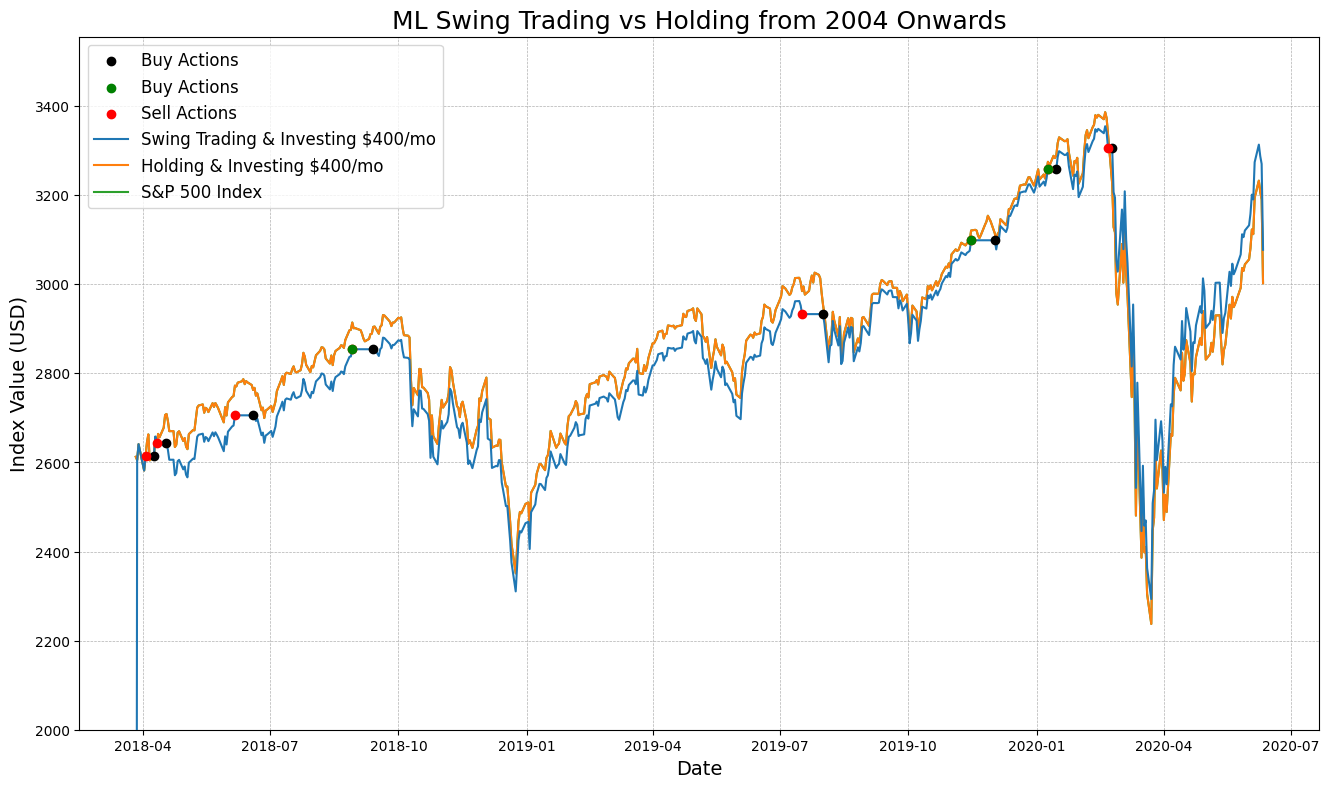

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
plt.scatter(test_df['Date'][:],buycounter[:],color='k',label='Buy Actions',zorder=4)
plt.scatter(test_df['Date'][:],branchcounter[:],color='g',label='Buy Actions',zorder=6)
plt.scatter(test_df['Date'][:],sellcounter[:],color='r',label='Sell Actions',zorder=5)
plt.plot(test_df['Date'][:],cash_record[:], label='Swing Trading & Investing $400/mo',zorder=3)
plt.plot(test_df['Date'][:],cash_record2[:], label='Holding & Investing $400/mo',zorder=2)
plt.plot(test_df['Date'][:],test_df['GSPC.Close'][:],label='S&P 500 Index',zorder=1)
ax.set_title('ML Swing Trading vs Holding from 2004 Onwards', fontsize=18)
#ax.set_yscale('log')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Index Value (USD)', fontsize=14)
#ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())
ax.set_ylim(bottom=2000)
ax.grid(which='both', linestyle='--', linewidth=0.5)
ax.legend(fontsize=12)
plt.show()